In [1]:
from Udep2Mono.polarization import PolarizationPipeline
import networkx as nx
import matplotlib.pyplot as plt
import binarytree as bt
from wordnet import find_relation, get_word_sets
from PIL import Image, ImageDraw
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display
import json
import _pickle as pickle
import os
import gensim.downloader as api
from Udep2Mono.dependency_parse import quantifier_replacement

2021-03-30 06:42:43 INFO: Loading these models for language: en (English):
| Processor | Package                  |
----------------------------------------
| tokenize  | ../model/e...ize/gum.pt  |
| pos       | ../model/en/pos/ewt.pt   |
| lemma     | ../model/en/lemma/gum.pt |
| depparse  | ../model/e...rse/gum.pt  |

2021-03-30 06:42:43 INFO: Use device: cpu
2021-03-30 06:42:43 INFO: Loading: tokenize
2021-03-30 06:42:43 INFO: Loading: pos
2021-03-30 06:42:43 INFO: Loading: lemma
2021-03-30 06:42:43 INFO: Loading: depparse
2021-03-30 06:42:44 INFO: Done loading processors!
2021-03-30 06:42:44 INFO: Loading these models for language: en (English):
| Processor | Package                 |
---------------------------------------
| tokenize  | ../model/e...ize/gum.pt |

2021-03-30 06:42:44 INFO: Use device: cpu
2021-03-30 06:42:44 INFO: Loading: tokenize
2021-03-30 06:42:44 INFO: Done loading processors!


In [2]:
#G = Ugraph()
nounModifiers = {"det", "nummod", "amod","obl:tmod", "acl:relcl", "nmod", "case","nmod:pass",  "acl", "Prime","cc"}
verbModifiers = {"advmod","xcomp","advcl","mark","aux"}
nounCategories = {"compound"}
verbs = {"VBZ", "VBP", "VBD", "VBG"}
modified = {"NN", "PRP", "JJ", "VB","RB"}.union(verbs)
modifiers = nounModifiers.union(verbModifiers)
offFocus = {"expl"}
contents = {"nsubj","obj","cop","compound","conj","nsubj:pass","obl"}
cont_npos = {"nsubj":'nn', "obj": 'nn', "cop": 'vbz', "verb": 'vbz'}
mark_toProp = {"+": {"hyponym","synonym"}, "-": {"hypernym","synonym"}, "=": {"synonym"}}
clause_prop = {"which", "that", "who"}
be_verbs = {"is", "am", "are", "be","was","were"}
directions = {0: "lexical", 1: "phrasal", 2: "syntatic_variation", 3: "implicative"}

In [3]:
#G.add_node("ok",id=1)
#G.add_node("fine")

In [4]:
#nx.draw(G, with_labels=True)
sentenceset = ["This are 2 specially cool dog food", "Animal cut fresh meat carefully every month"]
test1 = ["A lady cuts some meat", "A woman cuts some meat"]
testWhich = ["a lady who is beautiful drives a car that is old ", "A dog, which has a black coat, and a white dog are running on the grass","A beautiful woman drives a old car"]
testAnd = ["A girl eats an pear and an orange", "A black dog and a white dog are eating", "A girl makes and eats an apple", "A girl and a boy are carefully writing homework","A white and black dog is eating"]
testWith = ["A girl carries the bag with a tie", "A girl with a costume eats an apple", "A boy shocks the dog under the roof"]
testThere = ["There is a girl with a bag", "Here is the homework that I just wrote", "This is the pizza that I just ordered","There is no cat who playing with a device"]
testExtract = ["The beautiful girl who is wearing a bowtie and sitting on the chair eats a pretty pear", "The pretty woman wearing a bowtie eats a pear", "The beautiful girl eats a pear that has beautiful marks"]
test2 = ["A dog is eating food", "A dog is blue"]
testToComp = ["The person who is beautiful swims to exercise", "The person studys at noon to take an exam", "The pretty woman wearing a bowtie eats a pear to take an exercise", "This group of people is practicing water safety and wearing preservers"]
testIsDone = ["The book is placed on the ground", "The equipment is sound ", "We did not expect arrival of guests", "The fruit is eaten by the person"]
testIsDoing = ["I am writing the homework","Two children are climing a tree","The man who is sitting on a chair is eating food","They are studying at the classroom"]
testChunk = ["The equipment in front of the blond dancing girl is sound","Two men are standing near the water and are holding tools used for fishing"]
testTree = ["A dog that has a black and white coat is trotting through shallow water","A dog that has a white and black colored coat is trotting through shallow water"]
testControl = ["A dog and a cat are attacking and helping another animal", "A dog and a cat are helping and attacking another animal", 
                   "Two children are lying in the snow and are drawing angels","Two children are lying in the snow and are making angels",
                   "The woman is eating", "The woman is drinking"]
#det order
#add word/modifier
#"and" in connection 

In [5]:
arrows = {
    "+": "\u2191",
    "-": "\u2193",
    "=": "=",
    "0": ""
}
def annotation2string(annotation):
    annotated = list(annotation['annotated'].popkeys())
    def compose_token(word):
        if '-' in word[0]:
            orig = word[0].split('-')
            return ' '.join([x + arrows[word[2]] for x in orig])
        else:
            return word[0] + arrows[word[2]]
    annotated_sent = ' '.join([compose_token(x) for x in annotated])
    return annotated_sent

In [7]:
pipeline = PolarizationPipeline(verbose = 1)
results = []
results_tree = []
for sent in testThere:
    tree = pipeline.single_polarization(sent)["polarized_tree"]
    results_tree.append(tree)
    results.append(pipeline.postprocess(tree,""))
print(results)

['[expl↑  [EX  There↑]  [nsubj↑  [nmod↑  [case↑  [IN  with↑]  [det↑  [DT  a↑]  [NN  bag↑]]]  [det↑  [DT  a↑]  [NN  girl↑]]]  [VBZ  is↑]]]', '[advmod↑  [RB  Here↑]  [cop↑  [VBZ  is↑]  [det=  [DT  the↑]  [acl:relcl=  [nsubj=  [PRP  I=]  [advmod=  [RB  just=]  [obj=  [WDT  that=]  [VBD  wrote=]]]]  [NN  homework=]]]]]', '[nsubj↑  [DT  This↑]  [cop↑  [VBZ  is↑]  [det=  [DT  the↑]  [acl:relcl=  [nsubj=  [PRP  I=]  [advmod=  [RB  just=]  [obj=  [WDT  that=]  [VBD  ordered=]]]]  [NN  pizza=]]]]]', '[expl↑  [EX  There↑]  [nsubj↑  [det↓  [DT  no↑]  [acl:relcl↓  [nsubj↓  [WP  who↓]  [obl↓  [case↓  [IN  with↓]  [det↓  [DT  a↓]  [NN  device↓]]]  [VBG  playing↓]]]  [NN  cat↓]]]  [VBZ  is↓]]]']


In [8]:
class Unode:
    def __init__(self,prop,word,npos, mark):
        self.nexts = dict()
        self.prop = prop
        self.isRoot = False
        self.nexts["all"] = set()
        self.word = word
        self.npos = npos
        self.mark = mark
        self.phrases = set()
        self.pair = -1
        self.pairParts = dict()
        self.start = -1
        self.end = -1
        self.nodes = set()
        self.cc = None
        self.aligned = []
        self.alignedBy = []
        self.parent = None
        self.explMain = False
    def add_Unode(self, node):
        #print(node.prop)
        if(self.isRoot):
            if(node.prop == "obl"):
                node.prop = "obj"
            self.nexts[node.prop].add(node)
        else:
            self.nexts["all"].add(node)
    def addNode(self, node):
        self.nodes.add(node)
    def getText(self):
        if(self.isRoot):
            output = ""
            for cont in ["nsubj", "verb","obj"]:
                for ele in self.nexts[cont]:
                    output += ele.getText()
                    output += " "
            return output.strip()
        else:
            if(self.nexts["all"] == set()):
                return self.word
            output = self.word
            for element in self.nexts["all"]:
                if(element.prop == "amod"):
                    output = " " + output
                    output =  element.getText() + output
                else:
                    output += " "
                    output +=  element.getText()
                
            return output
    def get_inText(self, index):
        connected_info = ""
        if(self.isRoot):
            for key in self.nexts.keys():
                if(key != "all"):
                    print(key)
                    for keyItem in self.nexts[key]:
                        connected_info += (key + ": " + keyItem.get_inText(index + 1) + " ")
            return "{ " + connected_info + "}"
        else:
            for node in self.nexts["all"]:
                if(node != None):
                    #print("111")
                    connected_info += node.get_inText(index + 1)
            return "{ The " + str(index) + " layer" + ": " + self.word + connected_info + "}"
    def get_magicText(self):
        connected_info = ""
        if(self.isRoot):
            for key in self.nexts.keys():
                component = ""
                if(key != "all"):
                    print(key)
                    for keyItem in self.nexts[key]:
                        component += " (" + keyItem.get_magicText() + ")"
                    component = "(" + key + " " + component + ")"
                connected_info += component
            return "(" + connected_info + ")"
        else:
            for node in self.nexts["all"]:
                if(node != None):
                    #print("111")
                    connected_info +=  "(" + node.get_magicText() + ")"
            if(self.nexts["all"] == set()):
                if(self.pair != -1):
                    return self.word + str(self.pair)
                return self.word
            if(self.pair != -1):
                    return self.word + str(self.pair) + connected_info
            return  self.word + connected_info
    def addNum(self,num):
        self.pair = num
    def addPart(self, newNode, type1):
        if(type1 not in self.pairParts):
            self.pairParts[type1] = set()
        self.pairParts[type1].add(newNode)
    def getParts(self):
        ### return verb-obj subParts now
        return self.pairParts["obj"]
    def addCC(self,node):
        self.cc = node

In [9]:
class PairCounter:
    def __init__(self, initial = 0):
        self.nsubj = initial 
        self.obj = initial
    def incrementN(self):
        self.nsubj += 1
    def incrementO(self):
        self.obj += 1

In [10]:
class Ugraph:
    def __init__(self, rootNode):
        self.root = rootNode
        self.root.isRoot = True
        self.root.nexts.pop("all",None)
        for main in {"nsubj", "obj", "verb"}:
            self.root.nexts[main] = set()
        self.nodes = set()
        self.contentSet = set()
        self.chunks = set()
        self.Pairs = dict()
        self.Pairs["nsubj"] = dict()
        self.Pairs["obj"] = dict()
        self.align_log = []
        self.expl = False
    def add_node(self,node):
        self.nodes.add(node)
        self.root.addNode(node)
    def add_edge(self, node1, node2):
        if(node1.isRoot):
            self.contentSet.add(node2.word)
        node1.add_Unode(node2)
        node2.parent = node1
    def contains(self, word_assigned):
        return word_assigned in self.contentSet
    def get_magicText(self):
        return self.root.get_magicText()
    def addPair(self, newNode, num,type1):
        newNode.addNum(num)
        if(num not in self.Pairs[type1]):
            self.Pairs[type1][num] = [None]
        if(newNode.prop == "verb"):
            self.Pairs[type1][num][0] = newNode
        else:
            self.Pairs[type1][num].append(newNode)
        if(len(self.Pairs[type1][num]) > 1 and self.Pairs[type1][num][0] is not None):
            if(newNode.prop == "verb"):
                self.Pairs[type1][num][0].addPart(self.Pairs[type1][num][-1],"obj")
            else:
                self.Pairs[type1][num][0].addPart(newNode, "obj")

In [11]:
def print_as_graph(tree):
    G = nx.DiGraph()
    construct_treeGraph(tree,G)
    #G.add_node("this",id=2)
    nx.draw_planar(G, with_labels=True)

In [12]:
def print_tree_simple(tree):
    if(tree == "N"):
        return bt.Node("Not a Tree")
    root = bt.Node(tree.val)
    construct_tree(tree, root)
    print(root)

In [13]:
def construct_treeGraph(tree,G):
    if(tree == "N"):
        return
    else:
        if(tree.left != "N"):
            
            G.add_node(tree.left.val,id=1)
            G.add_edge(tree.val, tree.left.val)
            construct_treeGraph(tree.left,G)
        if(tree.right != "N"):
            #print(tree.right.npos==None)
            G.add_node(tree.right.val,id=1)
            G.add_edge(tree.val, tree.right.val)
            construct_treeGraph(tree.right,G)

In [14]:
def construct_tree(tree, subtree):
    if(tree == "N"):
        return
    if(tree.left != "N"):
        subtree.left = bt.Node(tree.left.val)
        construct_tree(tree.left, subtree.left)
    if(tree.right != "N"):
        subtree.right = bt.Node(tree.right.val)
        construct_tree(tree.right, subtree.right)
    

In [15]:
def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    cf.print_to_file('../data/tree_img/tree.ps')
    cf.destroy()
    os.system('magick convert ../data/tree_img/tree.ps ../data/tree_img/tree.png')
    display(Image(filename='../data/tree_img/tree.png'))

In [16]:
def visualize_tree(tree):
    btree = Tree.fromstring(tree.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btree)

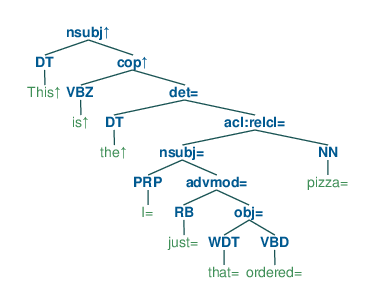

In [17]:
#print_as_graph(results[0][4])
visualize_tree(results[2])
#print_tree_simple(results[0][4])

In [18]:
def draw_graph():
    output = Image.new("RGB", (500, 500), (255,255,255))
    draw = ImageDraw.Draw(output)
    #draw.ellipse([100,100,200,200])
    draw.multiline_text((100, 100), "aaabbb\nword", fill=(0,0,0))
    output.show()

In [19]:
#draw_graph()

In [20]:
class graph_Info():
    def __init__(self,graph,crucials):
        self.graph = graph
        self.crucials = crucials

In [21]:
def mono2Graph(sent_info):
    G = Ugraph(Unode("root", "Root","r00t","="))
    #extract_NOV(sent_info, G)
    #print(G.root.nexts)
    #print(sent_info)
    counter = PairCounter()
    mono2Graph_recur(sent_info, G, set(),"verb",counter) ### root directly assigned for test here
    return G

In [22]:
def printUgraph_inText(Ugraph):
    print(Ugraph.root.get_inText(1))

In [23]:
def combine_comp(tree, node):
    if(tree.right == None):
        node.word = node.word + " " + quantifier_replacement.get(tree.val, tree.val)
        node.end = tree.id
        return
    else:
        node.word = node.word + " " + quantifier_replacement.get(tree.left.val, tree.left.val)
        return combine_comp(tree.right, node)

In [25]:
G = mono2Graph(results_tree[1])
print(results_tree[0] == None)
printUgraph_inText(G)
print(len(G.nodes))
for node_p in G.nodes:
    print(node_p.word+ "222")
print(G.root.nexts.keys())

False
nsubj
obj
nsubj
obj
verb
verb
{ obj: { The 2 layer: homework{ nsubj: { The 4 layer: I} obj: { The 4 layer: that} verb: { The 4 layer: wrote{ The 5 layer: just}} }{ The 3 layer: the}{ The 3 layer: Here}} verb: { The 2 layer: is} }
4
homework222
the222
is222
Here222
dict_keys(['nsubj', 'obj', 'verb'])


In [ ]:
# def extract_NOV(sent, G):
#     if(sent == "N"):
#         return
#     #print(sent.npos)
#     if((sent.val in contents or sent.npos in verbs) and not(sent.val in G.root.nexts.keys())):
#         print(sent.npos)
#         if sent.npos in verbs and sent.parent.val not in {"cop"}:
#             tempNode = Unode("verb", sent.val)
#         else:
#             if (sent != "N"):
#                 print(sent.val)
#             else:
#                 print(sent)
#             currentNode = sent.left
#             while(currentNode.right != "N"):
#                 currentNode = currentNode.right
#             tempNode = Unode(sent.val,currentNode.val)
#             G.add_node(tempNode)
#             G.add_edge(G.root, tempNode)
#             if(sent.val == "cop"):
#                 currentNode = sent.right
#                 while(currentNode.right != "N"):
#                     if(currentNode.val == "compound"):
#                         tempNode1 = Unode("obj",currentNode.left.val + " " + currentNode.right.val)
#                         G.add_node(tempNode1)
#                         G.add_edge(G.root, tempNode1)
#                         return
#                     currentNode = currentNode.right
#                 tempNode1 = Unode(sent.val,currentNode.val)
#                 G.add_node(tempNode1)
#                 G.add_edge(G.root, tempNode1)
        
#     #if(sent.val == "obj"):
#         #extract_NOV(sent.left, G)
#     extract_NOV(sent.right, G)

In [71]:
def mono2Graph_recur(sent_tree, G, mods, pos = None, counter = -1):
    needleft = True
    needright = True
    if(sent_tree is None):
        
        return
    #print(sent_tree.val)
    # 
    #if(sent_tree.nposif(sent_tree.val == "compound"):
    #         compound_out = sent_tree.left.val+" " + sent_tree.right.val
    #         G.add_node(compound_out)
    #         G.add_edge(root,compound_out)
    #         #ls.append(compound_out)
            
    #         return != None):
        #print(sent_tree.val + " " + sent_tree.parent.val)
        # if((sent_tree.npos in modified and sent_tree.npos != "JJ") or (sent_tree.parent!= "N" and sent_tree.parent.val == "nsubj")):
        #     ls.append(sent_tree.val)
        #     #G.add_node(sent_tree.val)
        #     G.add_node(sent_tree.parent.val,name=sent_tree.val)
        #     G.add_edge(root, sent_tree.parent.val)
        #     #G.add_edge(sent_tree.parent.val, sent_tree.val)
    #    print("")
    else:
        #print(sent_tree.val)
        if(any(list(map(lambda x: sent_tree.val is not None and x in sent_tree.val, list(modifiers))))):
            if("acl" in sent_tree.val):
                G_prime = mono2Graph(sent_tree.left)
                mods.add(G_prime.root)
            else:
                left_result = mono2Graph_recur(sent_tree.left, G, set(), sent_tree.val,counter)
                if(left_result is not None):
                    if(type(left_result) is set):
                        for item_result in left_result:
                            if(item_result is not None):
                                mods.add(item_result)
                    else:
                        mods.add(left_result)
            #print("000000000")
            #for item_print in mods:
            #    if(item_print!=None):
            #        print(item_print.word)
            #print("000000000")
            return mono2Graph_recur(sent_tree.right, G, mods, pos,counter)            
        else:
            if ((sent_tree.left is None and sent_tree.right is None) or sent_tree.val == "compound" ):
                    if("compound" in sent_tree.val):
                        right = sent_tree.right
                        comPos = right.pos
                        while(right != None):
                            comPos = right.pos
                            right = right.right
                        newNode = Unode(pos, quantifier_replacement.get(sent_tree.left.val, sent_tree.left.val),
                                        comPos, sent_tree.mark)
                        newNode.start = sent_tree.left.id
                        combine_comp(sent_tree.right, newNode)
                        if(pos in contents or pos == "verb"):
                                G.add_edge(G.root,newNode)
                                if(pos != "nsubj"):
                                    G.addPair(newNode, counter.obj,"obj")
                        for node in mods:
                                if(node.npos == "CC"):
                                    newNode.addCC(node)
                                else:
                                    G.add_edge(newNode, node)
                        return newNode
                    newNode = Unode(pos, quantifier_replacement.get(sent_tree.val, sent_tree.val), sent_tree.pos, sent_tree.mark)
                    newNode.start = sent_tree.id
                    newNode.end = sent_tree.id
                    G.add_node(newNode)
                    if (any(list(map(lambda x : sent_tree.pos is not None and x in sent_tree.pos, list(modified)))) 
                                                        or any(list(map(lambda x: pos is not None and x in pos, list(contents))))
                                                            or pos == "verb"):
                        if(pos in contents or pos == "verb"):
                            # if(pos in G.root.nexts.keys()):
                            #     print(G.root.nexts.keys())
                            #     print(pos)
                            #     print("Error occured in concentrating contents")
                            # else:
                                G.add_edge(G.root,newNode)
                                if(pos != "nsubj"):
                                    G.addPair(newNode, counter.obj,"obj")
                                    if(pos == "verb" and sent_tree.parent.val != "cop"):
                                        counter.incrementO()
                        for node in mods:
                            #if(G.contains(sent_tree.val)):
                                # loc = ""
                                # if(sent_tree.npos in verbs):
                                #     loc = "verb"
                                # else:
                                #     for key_cont in G.root.nexts.keys():
                                #         if(key_cont != "all"):
                                #             if(G.root.nexts[key_cont].word == sent_tree.val):
                                #                 loc = key_cont
                                #                 break
                                if(node.npos == "CC"):
                                    newNode.addCC(node)
                                else:
                                    G.add_edge(newNode, node)
                        return newNode
                    else:
                        mods.add(newNode)
                        return newNode
            else: 
                if(any(list(map(lambda x: sent_tree.val is not None and x in sent_tree.val, list(contents))))):
                    pos_left = sent_tree.val
                    pos_right = pos
                    if("nsubj" in sent_tree.val):
                        pos_right = "verb"
                        pos_left = sent_tree.val[0:5]
                    if("cop" in sent_tree.val):
                        target = sent_tree.right
                        ifObj = False
                        while(target != None):
                            if(target.val == "nsubj"):
                                break
                            if(target.val in ["obj", "obl"]):
                                ifObj = True
                                break
                            target = target.right
                        if(ifObj):
                            sent_tree.val = "aux"
                            return mono2Graph_recur(sent_tree, G, mods, pos,counter )
                        else:
                            pos_left = "verb"
                            pos_right = "obj" 
                            mono2Graph_recur(sent_tree.left, G,set(),pos_left,counter)
                            output = mono2Graph_recur(sent_tree.right, G, mods, pos_right,counter)
                            counter.incrementO()
                            return output
                    if('conj' in sent_tree.val):
                        if (any(list(map(lambda x: pos is not None and x in pos, list(modifiers))))):
                            results = set()
                            print(222)
                            results.add(mono2Graph_recur(sent_tree.left, G, set(), pos,counter))
                            results.add(mono2Graph_recur(sent_tree.right, G, set(), pos,counter))
                            return results
                        else:
                            mono2Graph_recur(sent_tree.left, G, set(), pos,counter)
                        
                            mono2Graph_recur(sent_tree.right, G, mods, pos,counter)
                        
                    elif("aux" in sent_tree.val):
                        mono2Graph_recur(sent_tree.right, G, mods, "verb",counter)
                    elif("ob" in sent_tree.val):
                        if(not pos in ["verb", "obj"]):
                            right_result = mono2Graph_recur(sent_tree.right, G, set(), "Prime",counter)
                            if(right_result is not None):
                                mods.add(right_result)
                            mono2Graph_recur(sent_tree.left, G, mods, pos_left, counter)
                        else:
                            mono2Graph_recur(sent_tree.left, G, set(),"obj",counter)
                            mono2Graph_recur(sent_tree.right, G, mods, "verb", counter)
                    else:
                        mono2Graph_recur(sent_tree.left, G,set(),pos_left,counter)
                        return mono2Graph_recur(sent_tree.right, G, mods, pos_right,counter)
                elif(any(list(map(lambda x: sent_tree.val is not None and x in sent_tree.val, list(offFocus))))):
                    if(sent_tree.val == "expl"):
                        G.expl = True
                    mono2Graph_recur(sent_tree.right, G, mods, pos,counter)
    #if(needleft):
    #    mono2Graph_recur(sent_tree.left, G, mods)
    #if(needright):
    #    mono2Graph_recur(sent_tree.right, G, mods)

In [ ]:
#def mono2Graph_categorize(sent_tree, G, root):
    

In [ ]:
# def find_nearest_belongTo(sent_tree, G, content_mark):
#     if(sent_tree == "N"):
#         print("Seems to have a parsing or binarization error")
#         return "", -2
#     if(sent_tree.npos == None):
#         if(sent_tree.val == "compound"):
#             comp_node = sent_tree.left.val + " " + sent_tree.right.val
#             if(comp_node in G.['dict'].keys()):
#                 print(comp_node)
#                 #G.nodes["C1"]['dict'].update({comp_node: content_mark})

#             return sent_tree, 2
#         return find_nearest_belongTo(sent_tree.right,G,content_mark)

#     elif (sent_tree.npos in modified or sent_tree.val in {"this", "these", "there", "that"} ):
#         if(sent_tree.parent.val in contents):
#             key = sent_tree.val
#             #print(sent_tree.val)
#             G.nodes["C1"]['dict'].update({key: sent_tree.parent.val})
#         return sent_tree, 1
#     else: 
#         print(sent_tree.val)
#         return "", -1

In [ ]:
#graph_out1 = mono2Graph(results[0])
#graph_out2 = mono2Graph(results[0])
#print(graph_out2.graph.nodes['obl:tmod'])
#nx.draw(graph_out2.graph, with_labels=True,center="C1")

In [ ]:
"compound" == ("a" or "compound" )

In [ ]:
G1 = mono2Graph(results_tree[0])
G2 = mono2Graph(results_tree[1])
#print(results_tree[0].left)
#print(results_tree[0].left.left is None)
printUgraph_inText(G1)
printUgraph_inText(G2)
jupyter_draw_nltk_tree(Tree.fromstring(G1.get_magicText()))
jupyter_draw_nltk_tree(Tree.fromstring(G2.get_magicText()))
print(G.root.nexts.keys())

In [ ]:
def check_alignment(graph1, graph2):
    return check_alignByRoot(graph1.root, graph2.root)

In [ ]:
def check_alignByRoot(root1, root2):
    for cont in {"nsubj", "verb", "obj"}:
        if(not(check_cont(root1, root2, cont))):
            print(cont)
            return "UnAligned"
    return "Aligned"  

In [ ]:
def check_cont(root1, root2, cont):
    core1 = root1.nexts[cont]
    core2 = root2.nexts[cont]
    return depth_check(core1, core2)


In [ ]:
def depth_check(node1, node2):
    if(node1.isRoot and node2.isRoot):
        return check_alignByRoot(node1, node2)
    if(node1.isRoot or node2.isRoot):
        return compare_nodeGraph(node1, node2)
    if(node1.pos != node2.pos and not(node1.pos in verbs and node2.pos in verbs)): 
        #currently on lexical level of comparison
        print(1)
        return False
    # if(len(node1.nexts["all"]) != len(node2.nexts["all"])):
    #     #currently only caring about equal numebr of qualifiers
    #     print(2)
    #     return False
    if(node1.mark != node2.mark):
        #currently only caring about same mark
        print("node with" + " " + node1.word + " " + node1.mark)
        print("node with" + " " + node2.word + " " + node2.mark)
        print(3)
        return False
    if((find_relation(node1.word, node2.word, node1.pos) not in mark_toProp[node1.mark]) and node1.word != node2.word):
        print("node with" + " " + node1.word + " " + node1.mark)
        print("node with" + " " + node2.word + " " + node2.mark)
        print(find_relation(node1.word, node2.word, node1.pos))
        print(4)
        return False
    for next1 in node1.nexts["all"]:
        corr_found = False
        for next2 in node2.nexts["all"]:
            if(next1.word == "Root"):
                print(next2.word)
            if(depth_check(next1, next2)):
                corr_found = True
                break
        if(not(corr_found)):
            print(5)
            print(next1.word)
            return False
    return True

In [ ]:
file = open("../data/SICK/train.txt", "r")
lines = file.readlines()
indexStart = 0
output = []
fileOut = open("./sickEntailment.txt", "w")
fileOut1 = open("./sickContradiction.txt", "w")
pipeline = PolarizationPipeline(verbose = 1)
# results = []
# results_tree = []
# for sent in testExtract:
#     tree = pipeline.single_polarization(sent)["polarized_tree"]
#     results_tree.append(tree)
#     results.append(pipeline.postprocess(tree,""))
# print(results)
i = 1
testNum = 65
for line in lines:
    if(i==testNum):
        # if(indexStart < 1):
        #     indexStart = indexStart + 1
        # else:
        argArr = line.split("\t")
        if(1):#argArr[4]=="ENTAILMENT\n"):
            #output.append(learn_variation(argArr[1], argArr[2], argArr[3], argArr[4][0:len(argArr[4])-2]))
            print(argArr[1])
            print(argArr[2])
            tree1 = pipeline.single_polarization(argArr[1])["polarized_tree"]
            tree2 = pipeline.single_polarization(argArr[2])["polarized_tree"]
            visualize_tree(pipeline.postprocess(tree1,""))
            visualize_tree(pipeline.postprocess(tree2,""))
            graph1 = mono2Graph(tree1)
            graph2 = mono2Graph(tree2)
            print(graph1.get_magicText())
            print(graph2.get_magicText())
            jupyter_draw_nltk_tree(Tree.fromstring(graph1.get_magicText()))
            jupyter_draw_nltk_tree(Tree.fromstring(graph2.get_magicText()))
            printUgraph_inText(graph1)
            printUgraph_inText(graph2)
                
            fileOut.write(line)
        if(argArr[4] == "CONTRADICTION\n"):
            fileOut1.write(line)
        
    elif(i>testNum): 
        break
    i+=1
#print(output)
file.close
fileOut.close
fileOut1.close

In [ ]:
def compare_nodeGraph(node, node2):
    if(node.isRoot):
        root = node
        wordNode = node2
    else:
        root = node2
        wordNode = node
    if(root.nexts["verb"].word in be_verbs):
        
        for adjs in {root.nexts["obj"]}:
            if(depth_check(wordNode, adjs)):
                return True
        return False

In [ ]:
def check_branch(node1, node2, label = "all"):
    if(node1.word != node2.word or len(node1.nexts) != len(node2.nexts)):
        return False
    toRemove = set()
    for next1 in node1.nexts[label]:
        cor = False
        for next2 in node2.nexts[label]:
                if(next1.word == next2.word and check_branch(next1, next2)):
                    cor = True
                    node2.nexts[label].remove(next2)
                    break
        if(cor):
            toRemove.add(next1)
    #print(list(k.word for k in toRemove))
    #print(list(k.word for k in node2.nexts[label]))
    for item in toRemove:
        node1.nexts[label].discard(item)
    #node1.nexts[label] = node1.nexts[label]-toRemove
    if(node1.nexts[label] == set() and node2.nexts[label] == set()):
        return True
    else:
        
        return False
                    

In [ ]:
def extract_syntatic_var(node1, node2):
   if (node2 == None):
       return node1.getText(),-1
   if (node1 == None):
       return -1, node2.getText()
   if(node1.nexts["all"] == set() or node2.nexts["all"] == set()):
       return -1, -1
   return node1.getText(), node2.getText()

In [ ]:
def learn_variation(sent1, sent2, score, rel):
    graph1 = mono2Graph(sent1)
    graph2 = mono2Graph(sent2)
    printUgraph_inText(graph1)
    printUgraph_inText(graph2)
    root1 = graph1.root
    root2 = graph2.root
    for cont in root1.nexts.keys():
        check_branch(root1, root2, cont)
        fileOut = open("./" + cont + "SyntacticVar" + ".txt", "w")
        list_ref1 = list(root1.nexts[cont])
        list_ref2 = list(root2.nexts[cont])
        size_iter = max(len(list_ref1), len(list_ref2))
        line1 = dict()
        line2 = dict()
        for i in range(size_iter):
            
            result1, result2 = extract_syntatic_var(list_ref1[i] if i < len(list_ref1) else None, list_ref2[i] if i < len(list_ref2) else None)
            if(result1 != -1):
                if(list_ref1[i].word not in line1.keys()):
                    line1[list_ref1[i].word] = set()
                line1[list_ref1[i].word].add(result1)
            if(result2 != -1):
                if(list_ref2[i].word not in line2.keys()):
                    line2[list_ref2[i].word] = set()
                line2[list_ref2[i].word].add(result2)
        print(line1,file=fileOut)
        print("\t",file=fileOut)
        print(line2,file=fileOut)
        print("\n",file=fileOut)
    printUgraph_inText(graph1)
    printUgraph_inText(graph2)
    return 2
#Problem with "and" in main cores alignment
#Problem with aligning different forms of the same word (i.e eat/eats, apple/apples, a/an)

In [ ]:
# def det_branch(graph1, graph2, label = "all"):
#     for
        

In [26]:
def insert_byOrder(nodeList, totalList):
    index = 0
    for i in range(len(totalList)):
        if(nodeList[-1].end is None):
            print(nodeList[-1].word)
        if(nodeList[-1].end < totalList[i][0].start):
            break
        index += 1
    totalList.insert(index,nodeList)
    return index

In [ ]:
A = [3]
A[-1]
A.insert(1,[3,5])
A[0:1]

In [27]:
class Chunk:
    def __init__(self, node, nodeList):
        self.node = node
        self.nodeList = nodeList
        self.ifVP = False

In [28]:
def check_nodesForChunk(nodeList, center, total):
    size = len(nodeList)
    splitpos = [0,size]
    for j in range(size -1):
        
        if(nodeList[j][-1].end + 1 != nodeList[j+1][0].start):
            if(j < center):
                if(j >= splitpos[0]):
                    splitpos[0] = j
            else:
                if((j+1) < splitpos[1]):
                    splitpos[1] = j+1
    outList = nodeList[splitpos[0]:splitpos[1]]
    newList = []
    for k in range(len(outList)):
        for node in outList[k]:
            newList.append(node)
    newChunk = Chunk(nodeList[center][0], newList)
    total.append(newChunk)
    return newChunk

In [29]:
def construct_sentence(root):
    listNodes = list(root.nodes)
    output = []
    for k in range(len(root.nodes)):
        index = 0
        for i in range(len(output)):
            if(listNodes[k].end < output[i].start):
                break
            index += 1
        output.insert(index,listNodes[k])
    newChunk = Chunk(None, output)
    return newChunk

In [30]:
def chunk_from_nodes(node, results, prep="all"):
    if(node.isRoot):
        make_chunks(node, results)
        #considering chunks from clause unrelated to main clause now
        output = construct_sentence(node)
        results.append(output)
        return output
    if(node.nexts[prep] == set()):
        return Chunk(node, [node])
    ##sorting goes:
    tempList = []
    for nodeItem in node.nexts[prep]:
        result = chunk_from_nodes(nodeItem, results)
        if(result is not None):
            if(nodeItem.cc != None):
                insert_byOrder([nodeItem.cc],tempList)
            insert_byOrder(result.nodeList, tempList)
    center = insert_byOrder([node],tempList)
    output = check_nodesForChunk(tempList, center, results)
    
    return output
    
    

In [31]:
def combine_conj_chunk(chunkList):
    out_results = []
    chunkList.sort(key=(lambda x: x.node.start))
    size = len(chunkList)
    splitIndex = 0
    if(chunkList != []):
        temp = Chunk(chunkList[0].node, chunkList[0].nodeList.copy())
    else:
        return []
    
    for j in range(size -1):
        if(chunkList[j+1].node.cc != None and chunkList[j].nodeList[-1].end + 1 == chunkList[j+1].node.cc.start):
            temp.nodeList += [chunkList[j+1].node.cc]
            temp.nodeList += chunkList[j+1].nodeList
        else:
            if(temp != []):
                out_results.append(temp)
            temp = Chunk(chunkList[j+1].node, chunkList[j+1].nodeList.copy())
    out_results.append(temp)
    
    return out_results

In [32]:
def make_chunks(graph_or_root, results):
    if(type(graph_or_root) is Ugraph):
        root = graph_or_root.root
    else:
        root = graph_or_root
    cont_out = dict()
    for cont in root.nexts.keys():
        for contNode in root.nexts[cont]:
            comp = chunk_from_nodes(contNode, results)
            if(cont in cont_out):
                cont_out[cont].append(comp)
            else:
                cont_out[cont] = []
                cont_out[cont].append(comp)
        if(cont in cont_out):
            cont_out[cont] = combine_conj_chunk(cont_out[cont])
            results += cont_out[cont]           
    if("verb" in cont_out and "obj" in cont_out):
        for vbChunk in cont_out["verb"]:
            for objChunk in cont_out["obj"]:
                if(vbChunk.node.pair == objChunk.node.pair):
                    vb = vbChunk.nodeList
                    obj = objChunk.nodeList
                    if(vb[-1].end +1 == obj[0].start):
                            vpChunk = Chunk(vbChunk.node, vb+obj)
                            vpChunk.ifVP = True
                            results.append(vpChunk)
    elif("verb" in cont_out and not "obj" in cont_out):
        for vbChunk in cont_out["verb"]:
                vbChunk.ifVP = True
                
    outList = set()
    for nodeChunk in results:
        tempStr = ""
        for node in nodeChunk.nodeList:
            tempStr += node.word
            tempStr += " "
        if(nodeChunk.ifVP):
            tempStr = "Somebody " + tempStr
        outList.add(tempStr.rstrip())
    return list(outList)

['who playing with a device', 'playing', 'who', 'no cat who playing with a device', 'Somebody is', 'with a device', 'Somebody playing with a device']


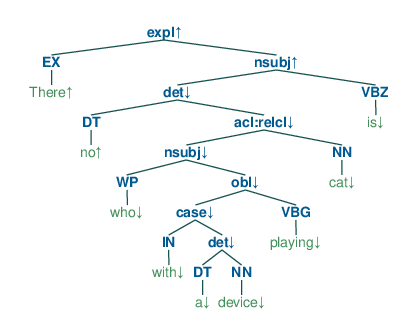

nsubj
nsubj
obj
verb
obj
verb


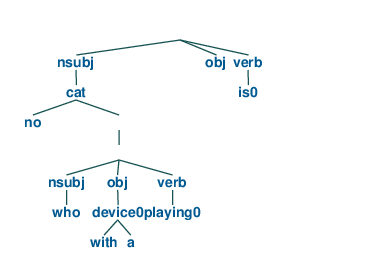

['that', 'Here the homework that I just wrote', 'I', 'is', 'just wrote', 'that I just wrote']


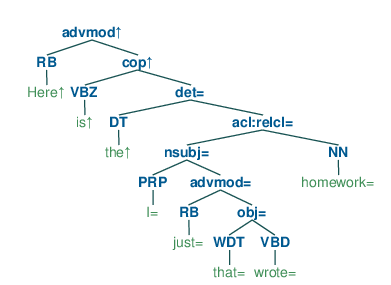

nsubj
obj
nsubj
obj
verb
verb


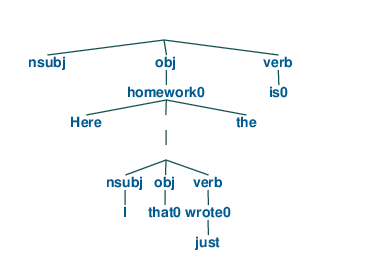

In [33]:
results = []
gh1 = mono2Graph(results_tree[3])
print(make_chunks(gh1, results))
visualize_tree(pipeline.postprocess(results_tree[3],""))
jupyter_draw_nltk_tree(Tree.fromstring(gh1.get_magicText()))

gh2 = mono2Graph(results_tree[1])
print(make_chunks(gh2, []))
visualize_tree(pipeline.postprocess(results_tree[1],""))
jupyter_draw_nltk_tree(Tree.fromstring(gh2.get_magicText()))

In [34]:
def lookForNot(node):
    if(not node.isRoot):
        nots = 0
        for nextNode in node.nexts["all"]:
            if(nextNode.word == "not"):
                nots += 1
        return nots%2 == 1
    else:
        return None

In [35]:
def check_notDet(node):
    for next1 in head1.nexts["all"]:
        if(next1.word != "not" and next1.npos != "DT"):
            for next2 in head2.nexts["all"]:
                if(next2.word != "not" and next2.npos != "DT"):
                    if(next1.word == next2.word):
                        return True
    return False

In [36]:
def check_node_con(head1, head2):
    if(head1.word == head2.word):
        ifNot1 = lookForNot(head1)
        ifNot2 = lookForNot(head2)
        condition = True
        if(ifNot1 != ifNot2):
            condition = False
        for next1 in head1.nexts["all"]:
            if(next1.word != "not"):
                for next2 in head2.nexts["all"]:
                    if(next2.word != "not"):
                        if(check_node_con(next1, next2) == condition):
                            return True
        return not condition
    else:
        word_sets = get_word_sets(head2.word.lower())
        return head1.word.lower() in word_sets[3] or (head1.mark == "+" and head1.word in word_sets[0]) or (head1.mark == "-" and head1.word in word_sets[1]) 

In [37]:
def check_contradiction(chunk1, chunk2):
    #sim_score = w2v_model.similarity(chunk1.node.word, chunk2.node.word)
    head1 = chunk1.node
    head2 = chunk2.node
    return check_node_con(head1, head2)
    

In [38]:
get_word_sets("cigarette")

({'roll of tobacco': 1,
  'smoke': 1,
  'a thing of the past...hopefully someday': 1,
  'device used for smoking': 1,
  'shredded tobacco': 1,
  'long thin object': 1},
 {'cubeb': 1,
  'cubeb cigarette': 1,
  'filter-tipped cigarette': 1,
  'joint': 1,
  'marijuana cigarette': 1,
  'reefer': 1,
  'stick': 1,
  'spliff': 1,
  'a fag': 1},
 {'cigarette': 1,
  'cigaret': 1,
  'coffin nail': 1,
  'butt': 1,
  'fag': 1,
  'smoke': 1,
  'roll up': 1,
  'cigar': 1,
  'tobacco': 1,
  'noncigarette': 1,
  'nicotine': 1,
  'doober': 1,
  'nonfilter': 1,
  'bifta': 1,
  'cancer stick': 1,
  'carton': 1,
  'quirly': 1,
  'vogue': 1,
  'flint': 1,
  'no smoking': 1},
 {})

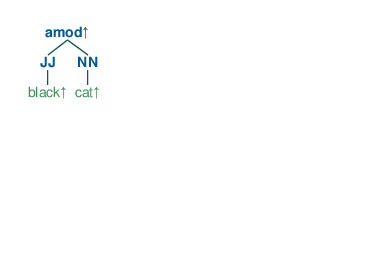

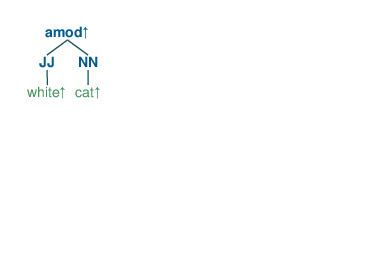

Is there contradiction: True
nsubj
obj
verb


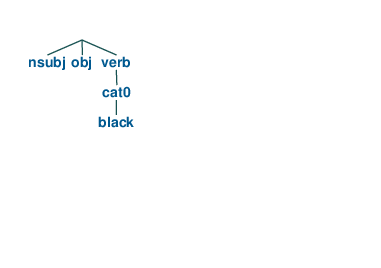

nsubj
obj
verb


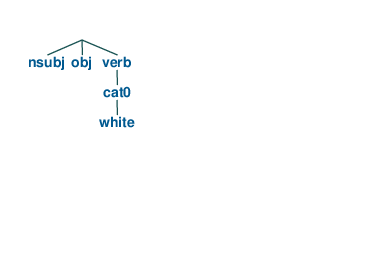

In [39]:
pipeline = PolarizationPipeline(verbose = 1)
chunk_set_adj1 = ["not not white cat", "white cat"]
chunk_set_adj2 = ["not white cat", "white cat"]
chunk_set_adj3 = ["black cat", "white cat"]
chunk_set_adj4 = ["pink cat", "white cat"]
chunk_set_adj5 = ["a black and tall cat", "white cat"]
chunk_set_adj6 = ["a mortal cat", "white cat"]


results = []
results_tree = []
for sent in chunk_set_adj3:
    tree = pipeline.single_polarization(sent)["polarized_tree"]
    results_tree.append(tree)
    result_str = pipeline.postprocess(tree,"")
    results.append(result_str)
    visualize_tree(result_str)

G1 = mono2Graph(results_tree[0])
G2 = mono2Graph(results_tree[1])
chunk1 = chunk_from_nodes(list(G1.root.nexts["verb"])[0],[])
chunk2 = chunk_from_nodes(list(G2.root.nexts["verb"])[0],[])
str333 = "Is there contradiction: {}"
print(str333.format(check_contradiction(chunk1, chunk2)))

#print(results_tree[0].left)
#print(results_tree[0].left.left is None)
jupyter_draw_nltk_tree(Tree.fromstring(G1.get_magicText()))
jupyter_draw_nltk_tree(Tree.fromstring(G2.get_magicText()))

In [ ]:
[l] + [4]
print("s" + None + "test")

In [ ]:
def chunk_extract(graph1):
    

In [ ]:
test111 = [1,2,3]
test222 = dict()
test222["app"] = [1,5]
test222.toString()
print(test222)
#test111[4]
print(0 if 1>0 else 1)

In [ ]:
learn_variation(results_tree[0], results_tree[2], 4.0, "entailment")

In [40]:
w2v_model = api.load("glove-wiki-gigaword-50")

In [ ]:
#import gensim.downloader as api
#model = api.load("conceptnet-numberbatch-17-06-300")

In [41]:
model.similarity('basketball', 'basketball')

NameError: name 'model' is not defined

In [42]:
from gensim.models.keyedvectors import KeyedVectors
#word_vecs = KeyedVectors.load_word2vec_format('../model/numberbatch-en.txt', binary=False)
#word_vecs.save('numberbatch-en.gensim')
model = KeyedVectors.load('numberbatch-en.gensim', mmap='r')
#model.similarity('basketball_game', 'basketball_court')

In [43]:
from nltk.stem.snowball import SnowballStemmer 
stemmer = SnowballStemmer(language = 'english')
tokens = ['make', 'computer', 'computed', 'computing']
for token in tokens:
    print(token + '-->' + stemmer.stem(token))

make-->make
computer-->comput
computed-->comput
computing-->comput


In [123]:
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp("Apples and oranges are similar. Boots and hippos aren't.")
for token in doc:
    print(token, token.lemma, token.lemma_)

Apples 8566208034543834098
and 2283656566040971221
oranges 2208928596161743350
are 10382539506755952630
similar 18166476740537071113
. 12646065887601541794
Boots 9918665227421442029
and 2283656566040971221
hippos 4133693291145879083
are 10382539506755952630
n't 2043519015752540944
. 12646065887601541794


In [ ]:
w2v_model.similarity('comput', 'people')

In [45]:
def check_type(node1, node2):
    npos1 = node1.npos
    npos2 = node2.npos
    if(npos1 is None):
        print('The word with none npos ', node1.word)
    if(npos2 is None):
        print('The word with none npos ', node2.word)
    if(npos1 in npos2 or npos2 in npos1):
        return 1
    if("VB" in npos1 and "VB" in npos2):
        return 1
    return 0

In [46]:
def check_sim(word1, word2):
    fill = 0.4
    if(word1 == word2):
        return 1.0
    try:
        output1 = w2v_model.similarity(word1, word2)
    except:
        output1 = -1
    if(output1 < 0.9):
        try:
            list1 = word1.split(' ')
            list2 = word2.split(' ')
            output2 = model.similarity('_'.join(list1), '_'.join(list2))
        except:
            output2 = -1
    else:
        output2 = -1
    if(output1 == -1 and output2 == -1):
        return fill
    return max(output1, output2)

In [ ]:
check_sim("basketball court", "basketball court")

In [47]:
def cal_sim_nodes(node1, node2, prop = 1.0):
    #node1,node2 both sets or both nodes
    ###not considering root with root case
    if(type(node1) is not set and type(node2) is not set and (node1.isRoot or node2.isRoot)):
        return 0
    if(type(node1) is set):
        set1 = node1
    else:
        set1 = node1.nexts["all"]
    if(type(node2) is set):
        set2 = node2
    else:
        set2 = node2.nexts["all"]
    if(set1 == set() or set2 == set()):
        if(type(node1) is not set):
            return prop * check_sim(node1.word.lower(), node2.word.lower())
        return 0
    nextSizes = min(len(set1), len(set2))
    tracked = set()
    outputRank = 0
    for nodeNext1 in set1:
        tempMax = [None, 0]
        for nodeNext2 in set2:
            if nodeNext2 not in tracked:
                rank = cal_sim_nodes(nodeNext1, nodeNext2, prop*0.4/nextSizes)
                if(rank >= tempMax[1]):
                    tempMax[0] = nodeNext2
                    tempMax[1] = rank
        if(tempMax[0] is None):
            break
        tracked.add(tempMax[0])
        outputRank += tempMax[1]
    if(type(node1) is set):
        return outputRank
    return 0.6*prop*check_sim(node1.word.lower(), node2.word.lower()) + outputRank
        
        

In [ ]:
def check_differenceOld(node1, node2, ranks):
    #indexs: 0->lexical 1->phrasal 2->syntatic variation 3->implicative
    if(not node1.isRoot and not node2.isRoot):
        roots1 = getRootNodes(node1)
        roots2 = getRootNodes(node2)
        rootPassed = set()
        for root1 in roots1:
            for root2 in roots2:
                outRank = control_direct(root1, root2)[1]
                ranks += outRank
                node2.nexts["all"].remove(root2)
                rootPassed.add(root1)
                break
        for passedRoot in rootPassed:
            roots1.remove(passedRoot)
    
    for nextNode1 in node1.nexts["all"]:
        
        related = []
        
        if(node2.nexts["all"] == set()):
            if(nextNode1.isRoot):
                ranks[2] += 1
            else:
                ranks[nextNode1.nexts["all"] != set()] += 1
            continue
        for nextNode2 in node2.nexts["all"]:
            #print(nextNode2.nexts)
            if_related = False
            if(nextNode1.isRoot != nextNode2.isRoot):
                if_related = True
                ranks[2] += 1
                break
            if(nextNode1.nexts["all"] == set() and nextNode2.nexts["all"] == set()):
               
                if_related = True
                if(nextNode1.word == nextNode2.word):
                    ranks[0] += 1
                break
            related.append(nextNode2)
        if(if_related):
            node2.nexts["all"].remove(nextNode2)
            related = []
        if(related != []):
            alignedNode = related[0]
            if(nextNode1.nexts["all"] == set()):
                ranks[2] += 1
            else:
                if(related[0].nexts["all"] == set()):
                    ranks[2] += 1
                else:
                    next_set = [0] * 4
                    check_difference(nextNode1, alignedNode, next_set)
                    sum = sum(next_set)
                    if(sum > 1):
                        if(nextNode1.word != alignedNode.word):
                            ranks[2] += 1
                        else:
                            ranks[1] += 1
                    elif((sum == 1) != (nextNode1.word != alignedNode.word)):
                        ranks[0] += 1
                    elif(sum ==1):
                        ranks[1] += 1 ##or simply ranks[0] += 2
                    else:
                        print("Error in check_difference because of process_branch")
                node2.nexts["all"].remove(related[0])
    if(node2.nexts["all"] != set()):
        for node2_left in node2.nexts["all"]:
            if(node2_left.isRoot):
                ranks[2] += 1
            else:
                ranks[node2_left.nexts["all"] != set()] += 1
        


In [48]:
def getRootNodes(node):
    output = set()
    for root in node.nexts["all"]:
        if(root.isRoot):
            output.add(root)
    return output

In [119]:
def align_nodes(node1, node2, G, label1 = "all", label2 = "all", fit=False):
    aligneded = set()
    for nextNode1 in node1.nexts[label1]:
        tempMax = [None, -1]
        for nextNode2 in node2.nexts[label2]:
            if(nextNode1.isRoot and nextNode2.isRoot):
                nextNode1.aligned.append(nextNode2)
                nextNode2.alignedBy.append(nextNode1)
                continue
            if(nextNode1.isRoot != nextNode2.isRoot):
                
                if(nextNode1.isRoot and not nextNode1.explMain):
                    align_nodes(nextNode1, node2, G, "obj", label2)
                elif(nextNode2.isRoot and not nextNode2.explMain):
                    align_nodes(node1, nextNode2, G, label1, "obj")
                    
                continue
            else:
                score = cal_sim_nodes(nextNode1, nextNode2) + 0.5*check_type(nextNode1, nextNode2)
            #print(nextNode1.word, '  ', nextNode2.word, score)
            if(score > tempMax[1]):
                tempMax[0] = nextNode2
                tempMax[1] = score
            #if(score > 0.8):
            #   tempMax.append(nextNode2)
        if(tempMax[1] > 0.7):
            nextNode1.aligned.append(tempMax[0])
            tempMax[0].alignedBy.append(nextNode1)
        for alignedOne in nextNode1.aligned:
            if(nextNode1.isRoot and alignedOne.isRoot):
                align_nodes(nextNode1, alignedOne, G, "nsubj","nsubj")
                align_nodes(nextNode1, alignedOne, G, "verb", "verb")
                align_nodes(nextNode1, alignedOne, G, "obj", "obj")
            elif(not nextNode1.isRoot and not alignedOne.isRoot ):
                align_nodes(nextNode1, alignedOne, G)
        #nextNode1.aligned += tempMax
        G.align_log.append("{} => {}".format(nextNode1.word, [node.word for node in nextNode1.aligned]))
    if(fit):
        for nextNode1 in node1.nexts[label1]:
            if(nextNode1.aligned == []):
                for nextNode2 in node2.nexts[label2]:
                    if(nextNode2.alignedBy == [] and nextNode1.isRoot == nextNode2.isRoot):
                        nextNode1.aligned.append(nextNode2)
                        nextNode2.alignedBy.append(nextNode1)
                        G.align_log.append("{} => {} by default".format(nextNode1.word, [node.word for node in nextNode1.aligned]))
    
                    
    
                

In [50]:
def find_Root(G):
    newRoot = G.root
    if(G.expl):
        for nodeSubj1 in G.root.nexts["nsubj"]:
            for nodeNext1 in nodeSubj1.nexts["all"]:
                if (nodeNext1.isRoot):
                    newRoot = nodeNext1
                    break
        newRoot.explMain = True
    return newRoot

In [121]:
def align_G(G1, G2):
    G1.align_log = []
    for nodeR in G2.nodes:
        nodeR.alignedBy = []
    newRoot1 = find_Root(G1)
    newRoot2 = find_Root(G2)
    #print(newRoot2.nexts["nsubj"])
    align_nodes(G1.root, G2.root, G1, "nsubj", "nsubj")
    align_nodes(newRoot1, newRoot2, G1, "verb", "verb")
    align_nodes(newRoot1, newRoot2, G1, "obj", "obj")
    print(G1.align_log)

In [52]:
w2v_model.similarity('in','a')

0.7958414

In [ ]:
from tqdm import tqdm
entail_p = []
entail_hypo = []
with open("../data/SICK/entail.txt") as upward_med:
    lines = upward_med.readlines()
    for i in range(len(lines) // 3):
        entail_p.append(lines[i*3])
        entail_hypo.append(lines[i*3+1])

In [53]:
def process_branch(node1, node2, label = "all"):
    toRemove = set()
    for nextNode1 in node1.nexts[label]:
        if(nextNode1.aligned != []):
            for alignedOne in nextNode1.aligned:
                #####
                if(alignedOne.isRoot and nextNode1.isRoot):
                    nsubjRe = process_branch(nextNode1, alignedOne, "nsubj")
                    verbRe = process_branch(nextNode1, alignedOne, "verb") 
                    objRe = process_branch(nextNode1, alignedOne, "obj")
                    ifRemove = nsubjRe and verbRe and objRe
                else:
                    ifRemove = process_branch(nextNode1, alignedOne)
                if(ifRemove):
                    toRemove.add(nextNode1)
                    if(alignedOne.parent == None):
                        node2.nexts[label].discard(alignedOne)
                    else:
                        alignedOne.parent.nexts[label].discard(alignedOne)
    for item in toRemove:
        node1.nexts[label].discard(item)
    
    
    if(node1.nexts[label] == set() and node2.nexts[label] ==set() and node1.word == node2.word):
        return True
    return False

In [96]:
def process_graph(G1, G2):
    process_branch(G1.root, G2.root, "nsubj")
    newRoot1 = find_Root(G1)
    newRoot2 = find_Root(G2)
    process_branch(newRoot1, newRoot2, "verb")
    process_branch(newRoot1, newRoot2, "obj")
    jupyter_draw_nltk_tree(Tree.fromstring(G1.get_magicText()))
    jupyter_draw_nltk_tree(Tree.fromstring(G2.get_magicText()))

In [55]:
import importlib
#importlib.reload(wordnet)

In [77]:
find_relation('man', 'people','NN')
get_word_sets('hang')

({'endowment': 1,
  'gift': 1,
  'talent': 1,
  'natural endowment': 1,
  'fit': 1,
  'gymnastic exercise': 1,
  'fasten': 1,
  'fix': 1,
  'secure': 1,
  'execute': 1,
  'put to death': 1,
  'drop': 1,
  'be': 1,
  'listen': 1,
  'grasp': 1,
  'hold on': 1,
  'obstruct': 1,
  'blockade': 1,
  'block': 1,
  'hinder': 1,
  'stymie': 1,
  'stymy': 1,
  'embarrass': 1,
  'decorate': 1,
  'adorn': 1,
  'grace': 1,
  'ornament': 1,
  'embellish': 1,
  'beautify': 1,
  'decompose': 1,
  'rot': 1,
  'molder': 1,
  'moulder': 1,
  'die': 1},
 {'bent hang': 1,
  'inverted hang': 1,
  'lever hang': 1,
  'reverse hang': 1,
  'straight hang': 1,
  'dangle': 1,
  'swing': 1,
  'drop': 1,
  'overhang': 1,
  'beetle': 1,
  'sling': 1,
  'suspend': 1,
  'gibbet': 1,
  'halter': 1,
  'brood': 1,
  'hover': 1,
  'loom': 1,
  'bulk large': 1,
  'fixate': 1},
 {'bent': 1,
  'knack': 1,
  'hang': 1,
  'hang up': 1,
  'string up': 1,
  'fall': 1,
  'flow': 1,
  'attend': 1,
  'advert': 1,
  'pay heed': 1,
 

In [57]:
contradict_verbs = {
        'perform':set(['fail']),
        'fail': set(['perform'])
}
det_type_words = {
    "det:univ": ["all", "every", "each", "any", "all-of-the"],
    "det:exist": ["a", "an", "some", "double", "triple", "some-of-the", "al-least", "more-than"],
    "det:limit": ["such", "both", "the", "this", "that",
                  "those", "these", "my", "his", "her",
                  "its", "either", "both", "another"],
    "det:negation": ["no", "neither", "never", "none", "none-of-the", "less-than", "at-most", "few"]
}

In [58]:
def det_con(node1, node2):
    word1 = node1.word
    word2 = node2.word
    

In [59]:
negation_words = ["no", "not", "n't"]
def find_not(node1, node2, label = "all"):
    nots = 0
    nots2 = 0
    for nextItem in node1.nexts[label]:
        if(nextItem.isRoot):
            for aligned in nextItem.aligned:
                nots += check_con(nextItem, aligned)
            continue
        if(nextItem.word in negation_words and not(nextItem.npos == "DT" and nextItem.aligned != [])):
            nots += 1
        elif(nextItem.npos == "DT" and nextItem.aligned != []):
            for alignedNext in nextItem.aligned:
                det_con(nextItem, alignedNext)
    for nextItem2 in node2.nexts[label]:
        if(nextItem2.word in negation_words and not(nextItem2.npos == "DT" and nextItem2.alignedBy != [])):
            nots2 += 1
        
    return nots, nots2

In [ ]:
def 

In [89]:
get_word_sets('empty')

({'container': 1,
  'change': 1,
  'alter': 1,
  'modify': 1,
  'change state': 1,
  'turn': 1,
  'leave': 1,
  'go forth': 1,
  'go away': 1,
  'remove': 1,
  'take': 1,
  'take away': 1,
  'withdraw': 1,
  'excrete': 1,
  'egest': 1,
  'eliminate': 1,
  'pass': 1},
 {'bail': 1,
  'bleed': 1,
  'clean out': 1,
  'clear out': 1,
  'clear': 1,
  'drain': 1,
  'evacuate': 1,
  'eviscerate': 1,
  'exhaust': 1,
  'gut': 1,
  'hollow': 1,
  'hollow out': 1,
  'core out': 1,
  'knock out': 1,
  'void': 1,
  'flow away': 1,
  'flow off': 1,
  'unload': 1,
  'unlade': 1,
  'offload': 1,
  'suction': 1},
 {'empty': 1,
  'discharge': 1,
  'vacate': 1,
  'abandon': 1,
  'evacuate': 1,
  'void': 1,
  'hollow': 1,
  'vacuous': 1,
  'empty-bellied': 1,
  'space': 1,
  'nothing': 1,
  'prittle prattle': 1,
  'emptiable': 1,
  'trace': 1,
  'holiday speeches': 1},
 {'fill': 1,
  'full': 1,
  'non empty': 1,
  'crowd': 1,
  'filling': 1,
  'oxygen': 1,
  'furnish': 1})

In [82]:
def check_con(root1, root2):
    notUps = 0
    notDowns = 0
    for node1 in root1.nexts["nsubj"]:
        if(node1.word.lower() in ["nobody","nothing"]):
            notUps += 1
        for aligned in node1.aligned:
            if(aligned.word.lower() in ["nobody", "nothing"]):
                notDowns += 1
        
        if(notUps ==0 and notDowns ==0):
            for nodeNext1 in node1.nexts["all"]:
                if(nodeNext1.word in negation_words):
                    notUps += 1
            for aligned in node1.aligned:
                for nodeNext2 in aligned.nexts["all"]:
                    if(nodeNext2.word in negation_words):
                        notDowns += 1
                        
    nsubjNot = abs(notUps-notDowns)%2
    notUps = 0
    notDowns = 0
    
    for nodev in root1.nexts["verb"]:
        if(notUps ==0 and notDowns ==0):
            for alignedv in nodev.aligned:
                #if(alignedv.word != nodev.word):
                #    return 3
                wordv = stemmer.stem(nodev.word.lower())
                alignwordv = stemmer.stem(alignedv.word.lower())
                #print(wordv)
                #print(alignwordv)
                try:
                    notUps += wordv in get_word_sets(alignwordv)[3] or alignwordv in get_word_sets(wordv)[3] \
                                            or wordv in contradict_verbs.get(alignwordv, set())     
                except:
                    notUps += 0
                nots = find_not(nodev, alignedv)
                notUps += nots[0]
                notDowns += nots[1]
    
    verbNot = abs(notUps-notDowns)%2
    #print(verbNot)
    
    notUps = 0
    notDowns = 0
    for nodeo in root1.nexts["obj"]:
        if(notUps ==0 and notDowns ==0):
            for alignedo in nodeo.aligned:
                try:
                    notUps += nodeo.word.lower() in get_word_sets(alignedo.word.lower())[3]
                except:
                    notUps += 0
                #if(nodeo.isRoot and alignedo.isRoot):
                    #print()
                    #notUps += check_con(nodeo, alignedo) #(find_not(nodeo,"nsubj") + find_not(nodeo,"verb") + find_not(nodeo,"obj"))
                    #notDowns += (find_not(alignedo, "nsubj") + find_not(alignedo, "verb") + find_not(alignedo, "obj"))
                #else:
                nots = find_not(nodeo, alignedo)
                notUps += nots[0]
                notDowns += nots[1]
            
    objNot = abs(notUps-notDowns)%2
    
    if((verbNot+nsubjNot+objNot)%2 == 1 ):
        return 1
    
    return 0

In [ ]:
abs(2-3)

In [ ]:
A = set()
A.add(2)
len(A)

In [ ]:
'''for next2 in node2.nexts[label]:
            if(next2.word.lower() in [ "not","n't"]):
                numNot +=1
        if(numNot==0):
            for next1 in node1.nexts[label]:
                if(next1.word.lower() in ["not","n't"]):
                    numNot += 1
        if(numNot %2 ==1):
            logs.append("{} happens under node {} with id {}".format('negation', node1.word, node1.start))
        else:
'''

In [ ]:
check_sim('motorcycle', 'motorbike')

In [ ]:
model.similarity('motorcycle', 'motorbike')

In [61]:
def control_direct(node1, node2, ranks, logs, label="all"):
    if(not node1.isRoot and not node2.isRoot and node1.nexts[label] == set() and node2.nexts[label] == set() 
               and node1.word.lower() != node2.word.lower()):
        ranks[0] += 1
        logs.append([0, node1.start, node2.start, node1.word, node2.word])
        return
    ##
    for node11 in node1.nexts[label]:
        if(node11.aligned == [] and not node11.explMain):
            ranks[1] += 1
            logs.append([1, node11.start, -1,node11.word,None])
    for node22 in node2.nexts[label]:
        if(node22.alignedBy == [] and not node22.explMain):
            ranks[1] += 1
            logs.append([1, -1, node22.start, None, node22.word])
    
    if(check_sim(node1.word.lower(), node2.word.lower()) > 0.9):#node1.word.lower() == node2.word.lower() or 
        if(node1.word.lower() != node2.word.lower()):
            ranks[0] += 1
            logs.append([0, node1.start, node2.start, node1.word, node2.word])
        for new1 in node1.nexts[label]:
            for new2 in new1.aligned:
                if(new1.isRoot and new2.isRoot):
                    control_direct(new1, new2, ranks, logs,"nsubj")
                    control_direct(new1, new2, ranks, logs, "verb")
                    control_direct(new1, new2, ranks, logs, "obj")
                else:
                    control_direct(new1, new2, ranks, logs)
    else:
        ranks[2] += 1
        logs.append([2, node1.start, node2.start, node1.word, node2.word])

In [65]:
def control_graph(G1, G2):
    ranks = [0] * 3
    logs = []
    newRoot1 = find_Root(G1)
    newRoot2 = find_Root(G2)
    control_direct(G1.root, G2.root, ranks, logs, "nsubj")
    control_direct(newRoot1, newRoot2, ranks, logs, "verb")
    control_direct(newRoot1, newRoot2, ranks, logs, "obj")
    #print(logs)

In [63]:
"The player is missing the basket and a crowd is in background"
"The player is dunking the basketball into the net, and a crowd is in background"

'The player is dunking the basketball into the net, and a crowd is in background'

In [64]:
con_p = []
con_hypo = []
with open("../data/SICK/contradict.txt") as sick_noun:
    lines = sick_noun.readlines()
    for i in range(len(lines) // 3):
        con_p.append(lines[i*3])
        con_hypo.append(lines[i*3+1])


In [ ]:
w2v_model.similarity('contains', 'contain')


In [ ]:
model.similarity('contains', 'contain')

In [ ]:
w2v_model.similarity('bike', 'black')

In [91]:
stemmer.stem('emptying')+'e'

'emptie'

In [ ]:
i=150
print(con_p[i])
print(con_hypo[i])

nsubj
obj
verb


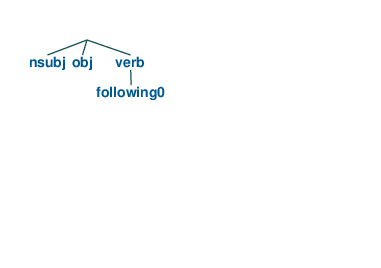

nsubj
obj
verb


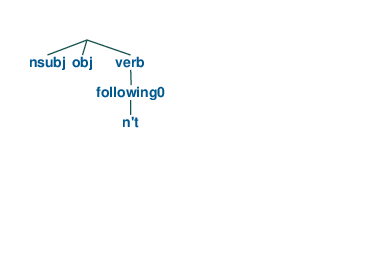

nsubj
obj
verb


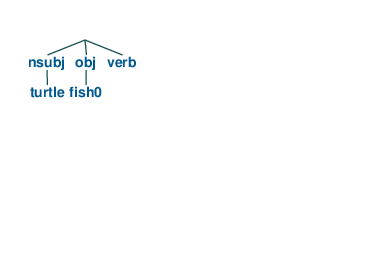

nsubj
obj
verb


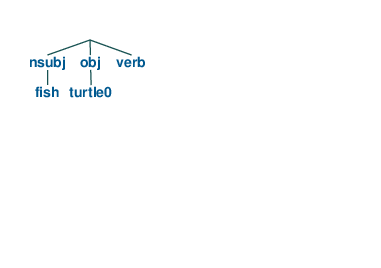

nsubj
nsubj
obj
verb
obj
verb


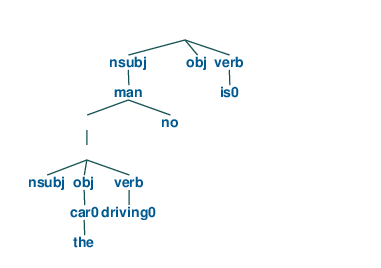

nsubj
obj
verb


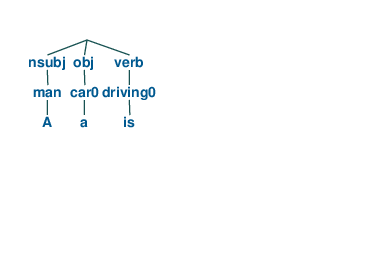

nsubj
nsubj
obj
verb
obj
verb


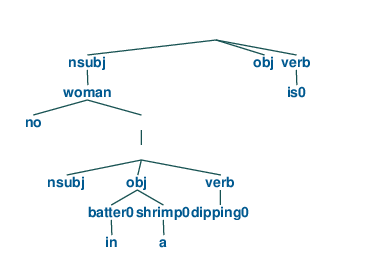

nsubj
obj
verb


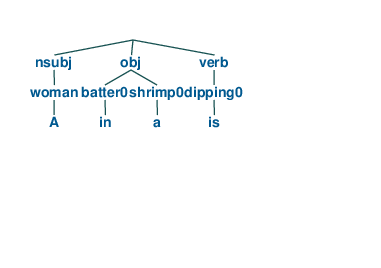

nsubj
obj
verb


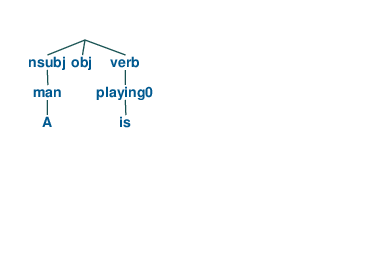

nsubj
nsubj
obj
verb
obj
verb


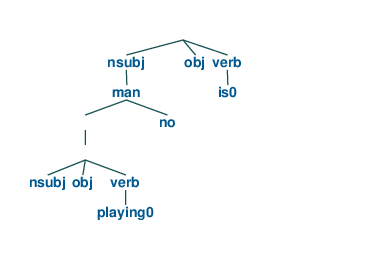

nsubj
obj
verb


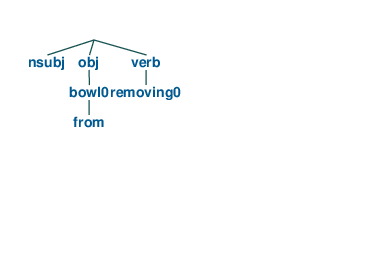

nsubj
obj
verb


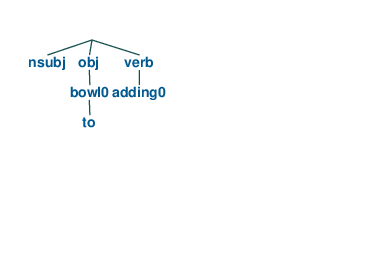

nsubj
obj
verb


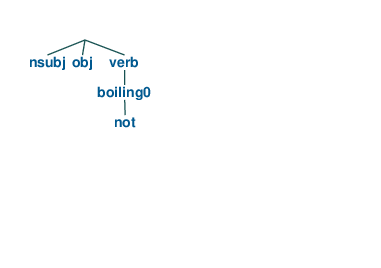

nsubj
obj
verb


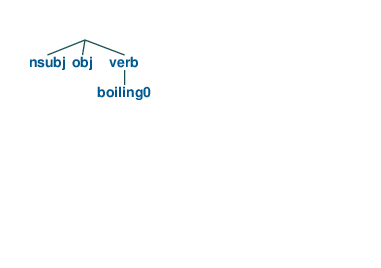

nsubj
obj
verb


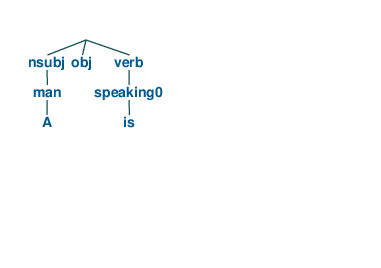

nsubj
nsubj
obj
verb
obj
verb


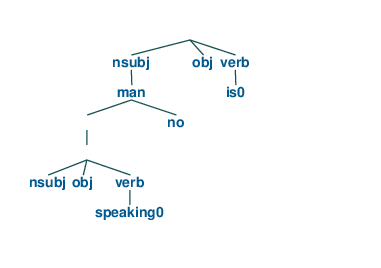

nsubj
obj
verb


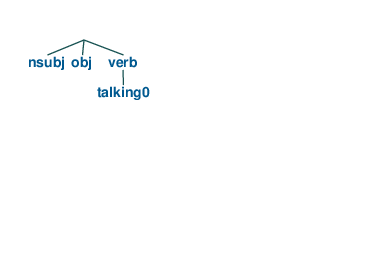

nsubj
obj
verb


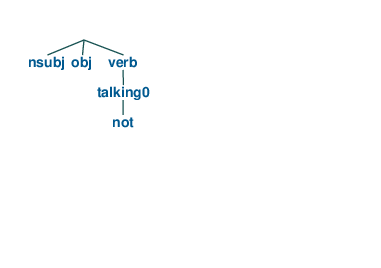

nsubj
nsubj
obj
verb
obj
verb


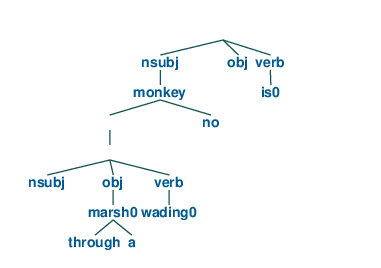

nsubj
obj
verb


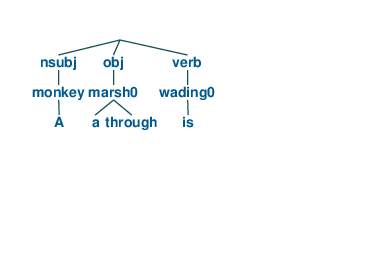

nsubj
obj
verb


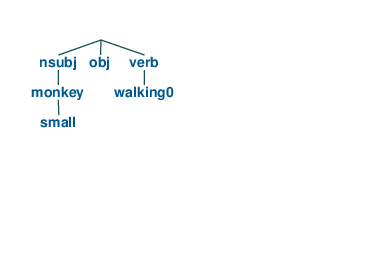

nsubj
obj
verb


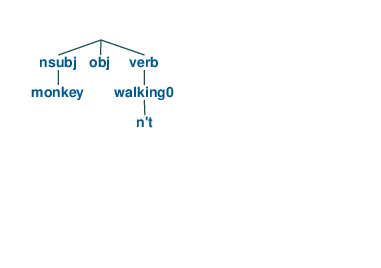

nsubj
obj
verb


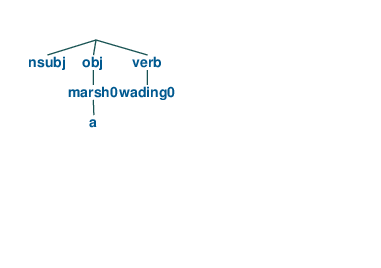

nsubj
obj
verb


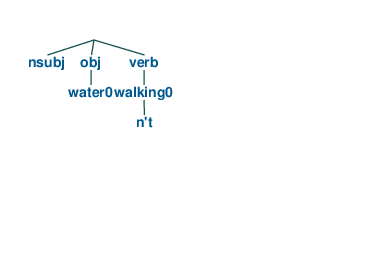

nsubj
obj
verb


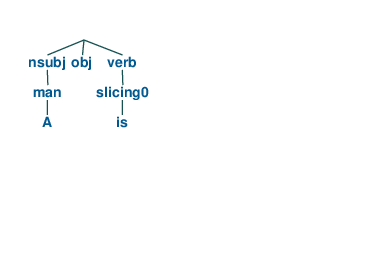

nsubj
nsubj
obj
verb
obj
verb


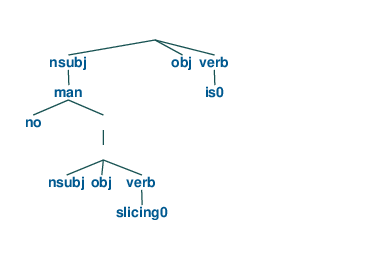

nsubj
obj
verb


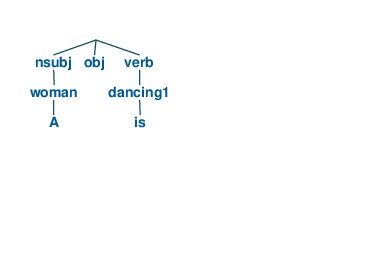

nsubj
nsubj
obj
verb
obj
verb


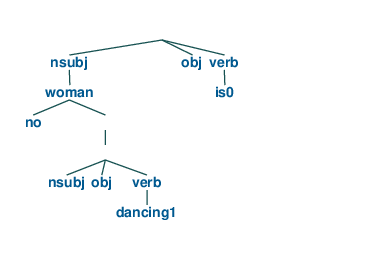

nsubj
obj
verb


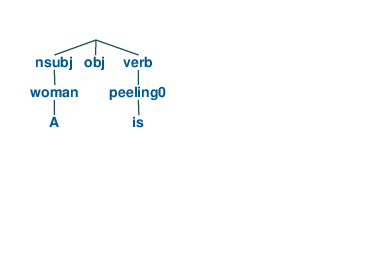

nsubj
nsubj
obj
verb
obj
verb


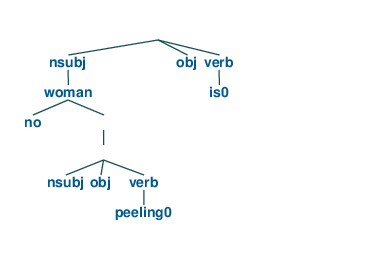

nsubj
obj
verb


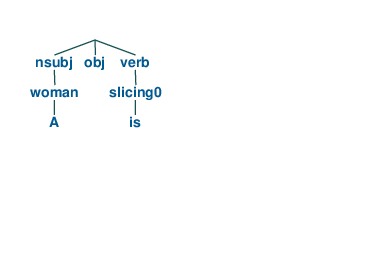

nsubj
nsubj
obj
verb
obj
verb


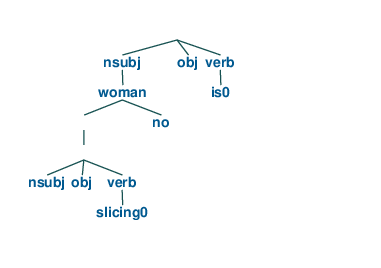

nsubj
nsubj
obj
verb
obj
verb


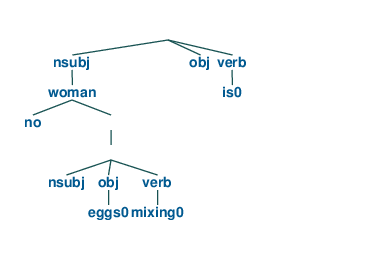

nsubj
obj
verb


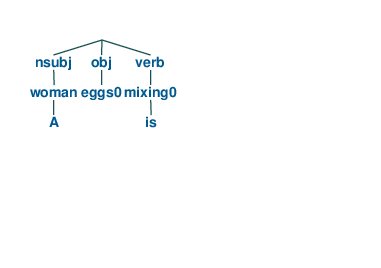

nsubj
obj
verb


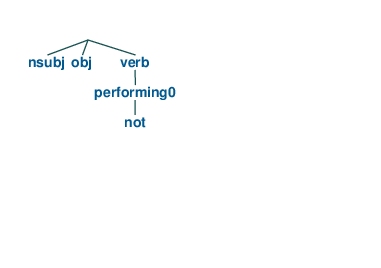

nsubj
obj
verb


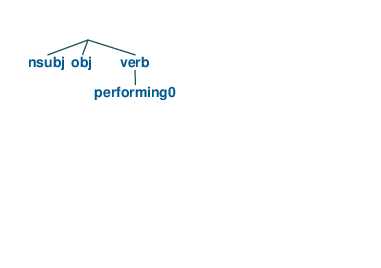

nsubj
obj
verb


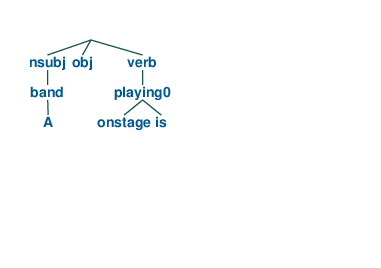

nsubj
obj
verb


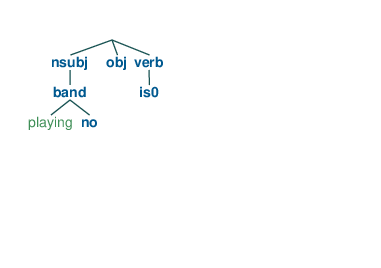

nsubj
obj
verb


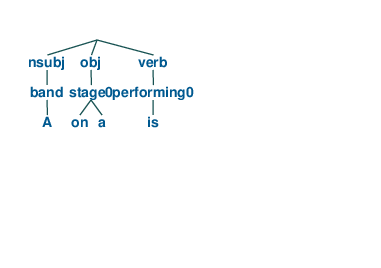

nsubj
obj
verb


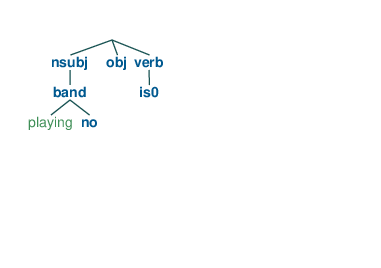

nsubj
obj
verb


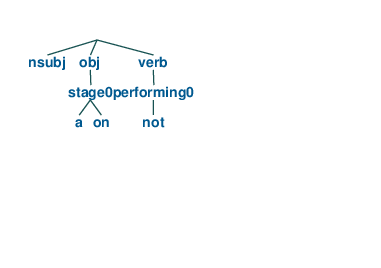

nsubj
obj
verb


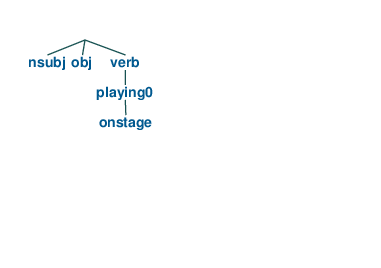

nsubj
obj
verb


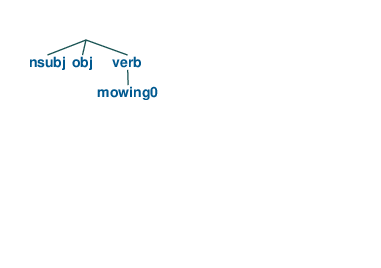

nsubj
obj
verb


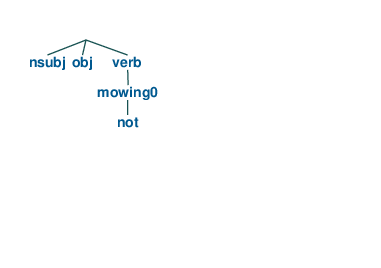

nsubj
obj
verb


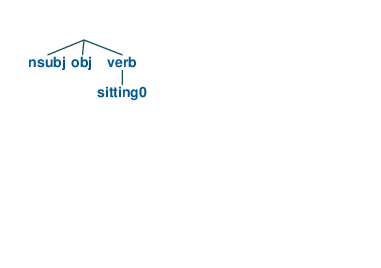

nsubj
obj
verb


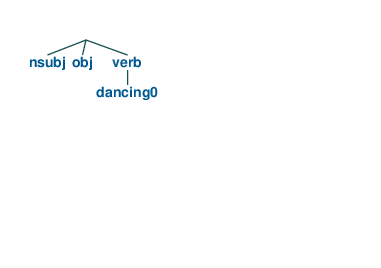

nsubj
nsubj
obj
verb
obj
verb


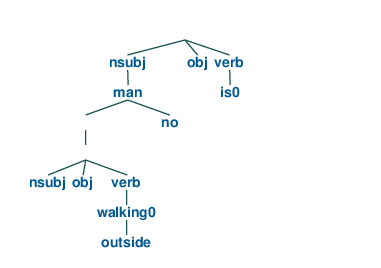

nsubj
obj
verb


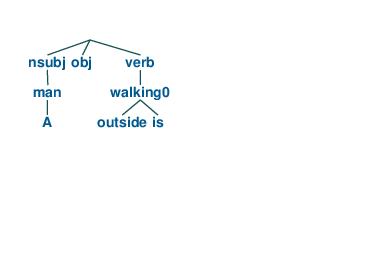

nsubj
nsubj
obj
verb
obj
verb


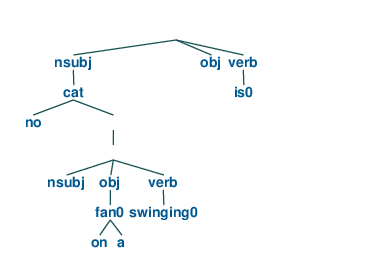

nsubj
obj
verb


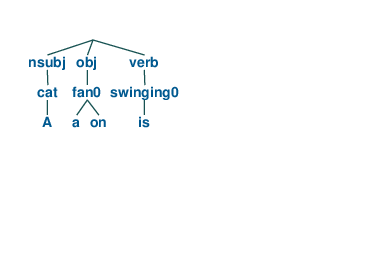

nsubj
nsubj
obj
verb
obj
verb


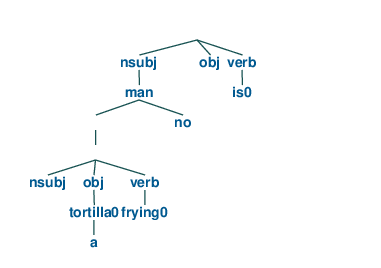

nsubj
obj
verb


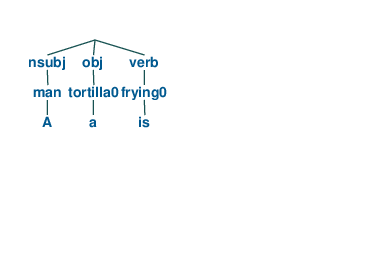

nsubj
obj
verb


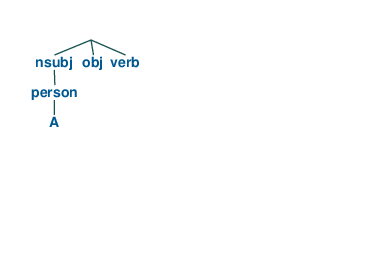

nsubj
obj
verb


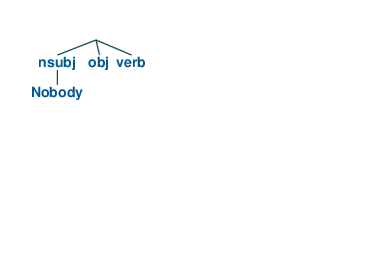

nsubj
obj
verb


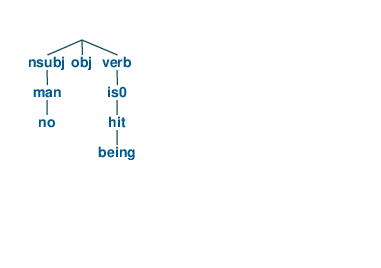

nsubj
obj
verb


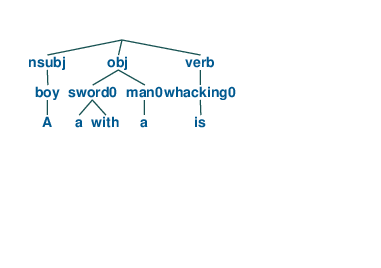

nsubj
obj
verb


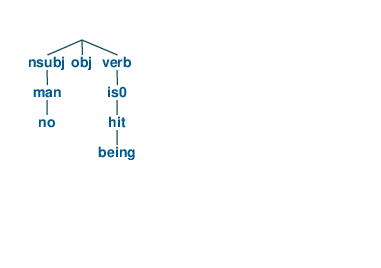

nsubj
obj
verb


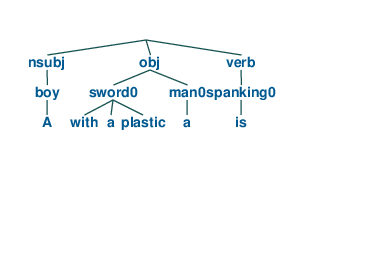

nsubj
obj
verb


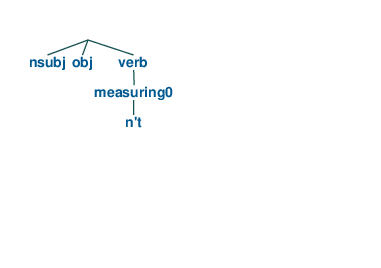

nsubj
obj
verb


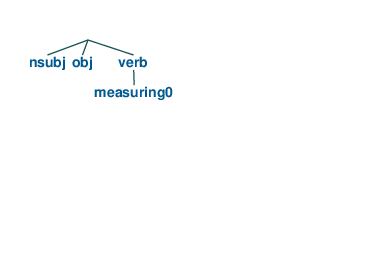

nsubj
obj
verb


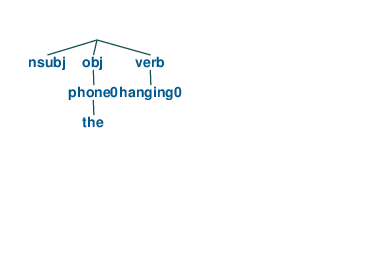

nsubj
obj
verb


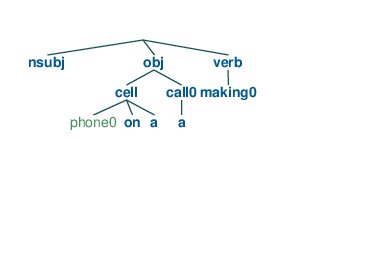

nsubj
nsubj
obj
verb
obj
verb


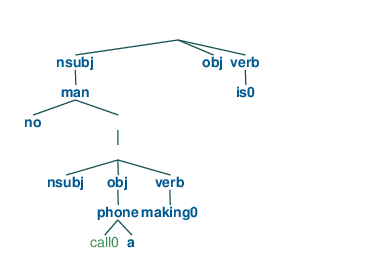

nsubj
obj
verb


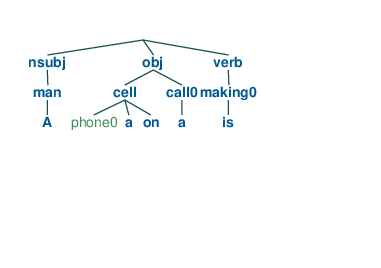

nsubj
nsubj
obj
verb
obj
verb


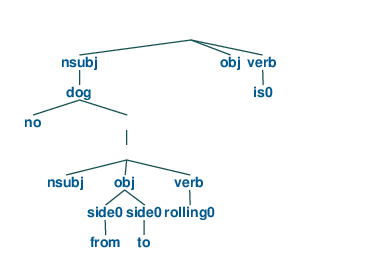

nsubj
obj
verb


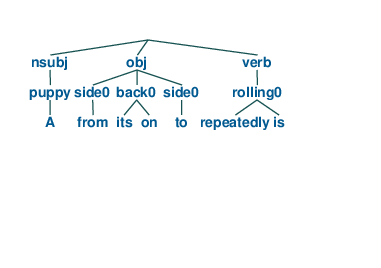

nsubj
obj
verb


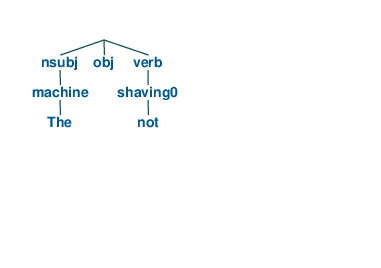

nsubj
obj
verb


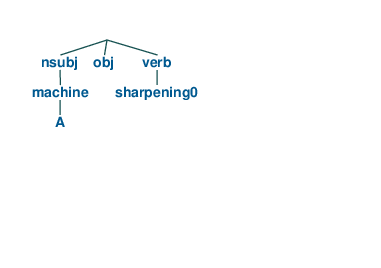

nsubj
obj
verb


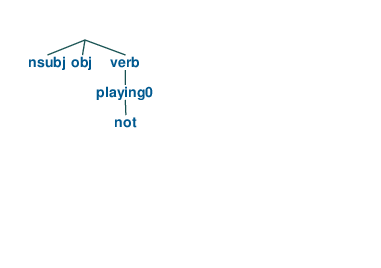

nsubj
obj
verb


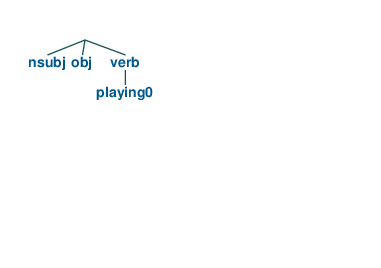

nsubj
obj
verb


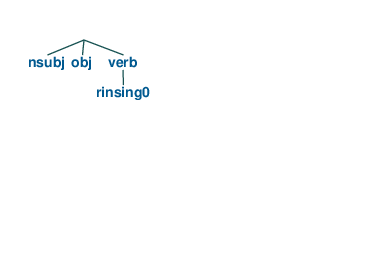

nsubj
obj
verb


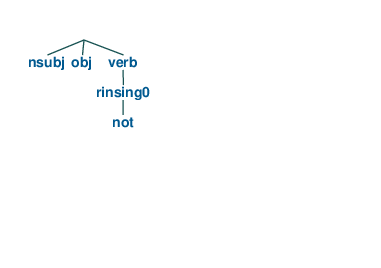

nsubj
obj
verb


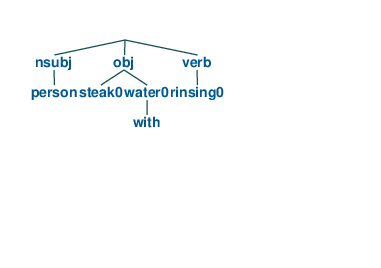

nsubj
obj
verb


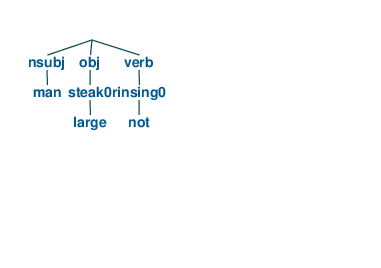

nsubj
obj
verb


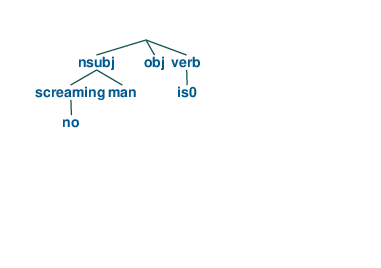

nsubj
obj
verb


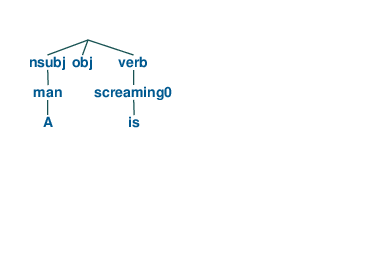

nsubj
obj
verb


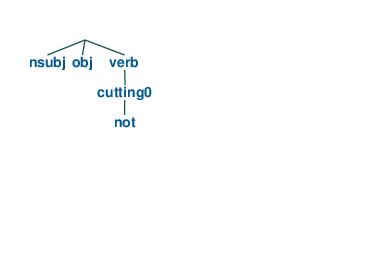

nsubj
obj
verb


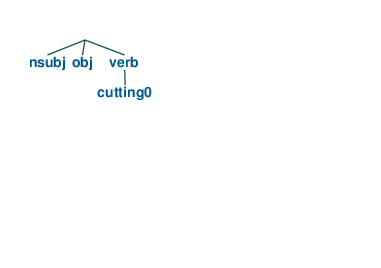

nsubj
obj
verb


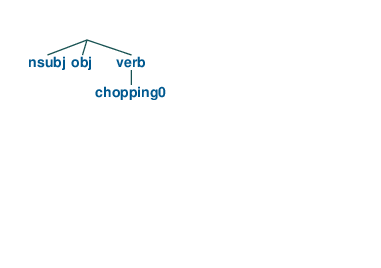

nsubj
obj
verb


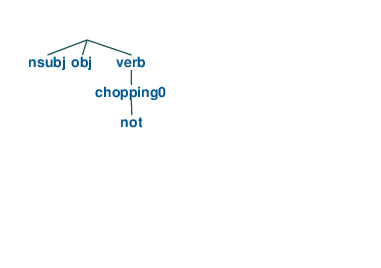

nsubj
nsubj
obj
verb
obj
verb


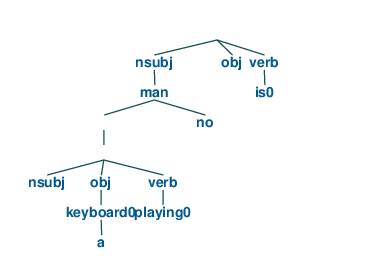

nsubj
obj
verb


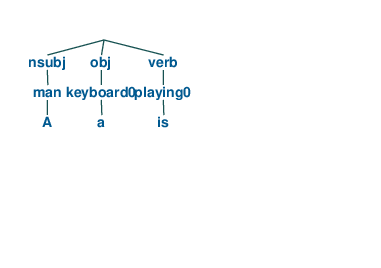

nsubj
obj
verb


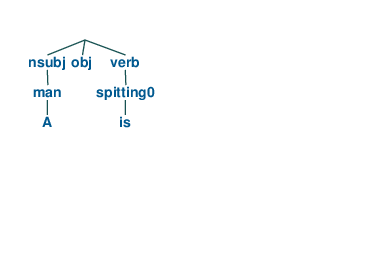

nsubj
obj
verb


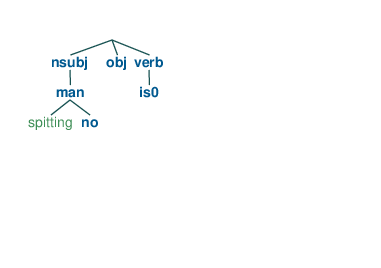

nsubj
obj
verb


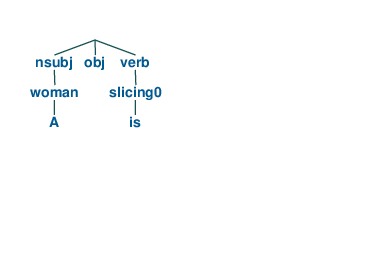

nsubj
nsubj
obj
verb
obj
verb


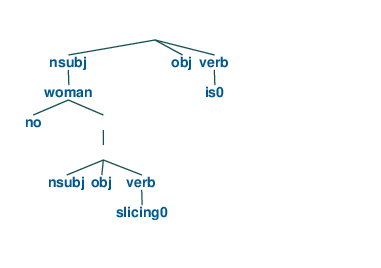

nsubj
obj
verb


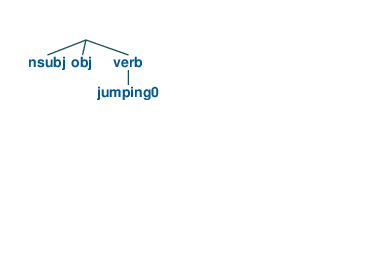

nsubj
obj
verb


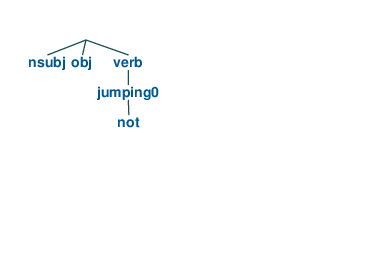

nsubj
obj
verb


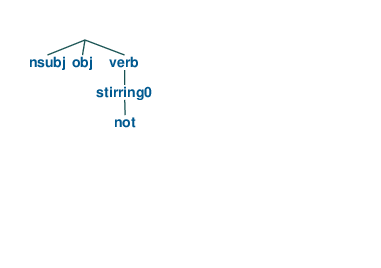

nsubj
obj
verb


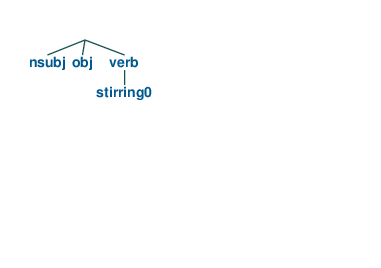

nsubj
obj
verb


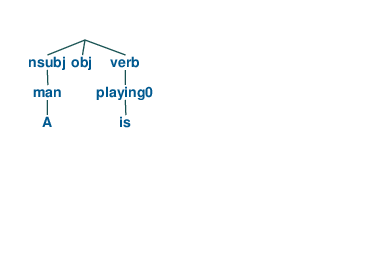

nsubj
nsubj
obj
verb
obj
verb


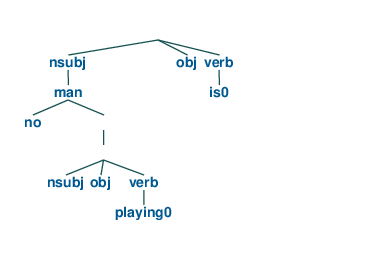

nsubj
nsubj
obj
verb
obj
verb


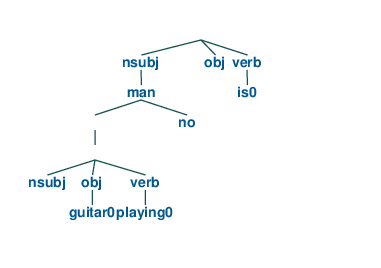

nsubj
obj
verb


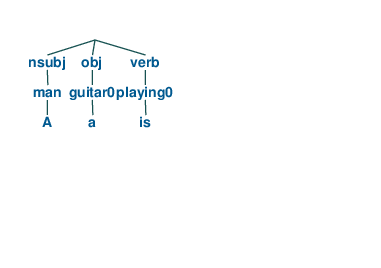

nsubj
obj
verb


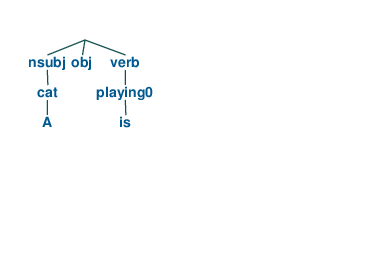

nsubj
nsubj
obj
verb
obj
verb


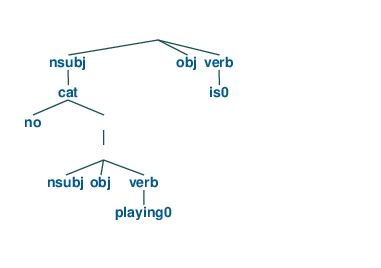

nsubj
nsubj
obj
verb
obj
verb


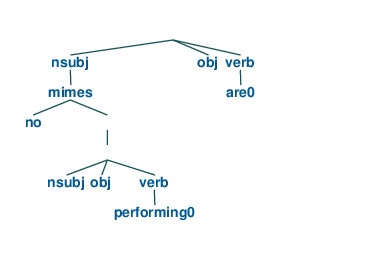

nsubj
obj
verb


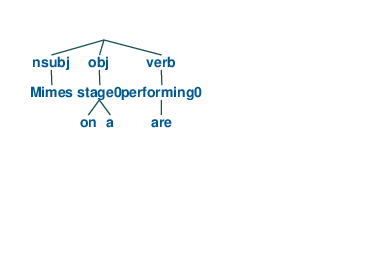

nsubj
obj
verb


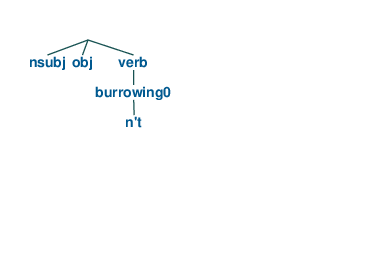

nsubj
obj
verb


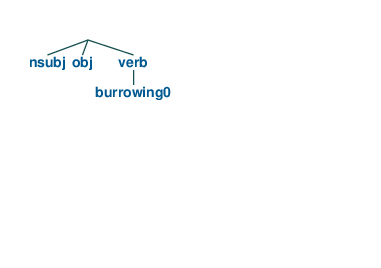

nsubj
nsubj
obj
verb
obj
verb


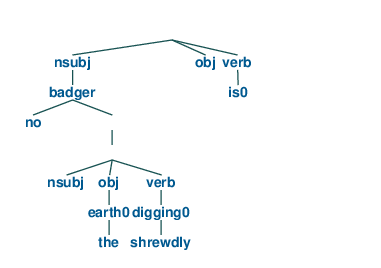

nsubj
obj
verb


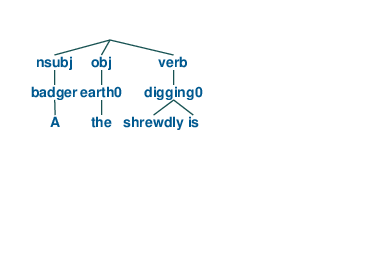

nsubj
obj
verb


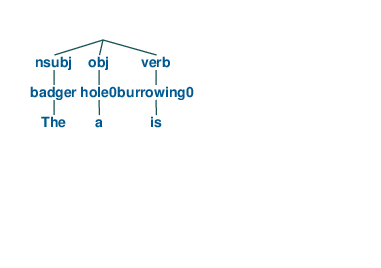

nsubj
nsubj
obj
verb
obj
verb


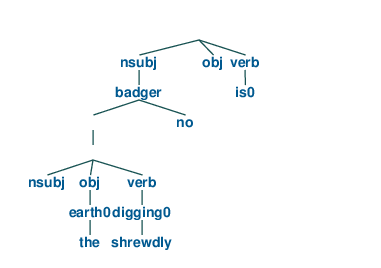

nsubj
obj
verb


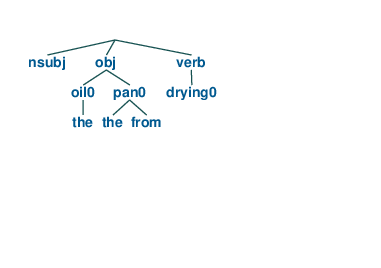

nsubj
obj
verb


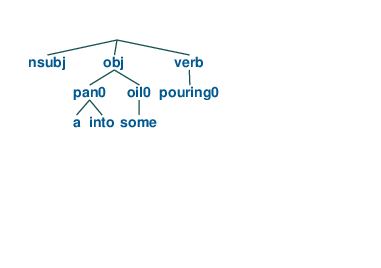

nsubj
obj
nsubj
obj
verb
verb


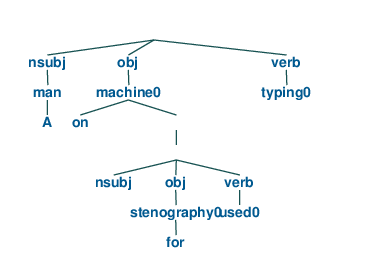

nsubj
obj
verb


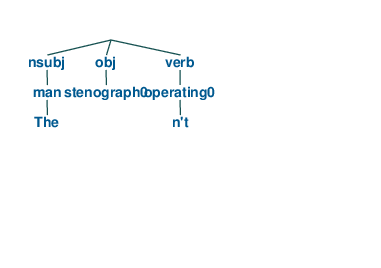

nsubj
obj
verb


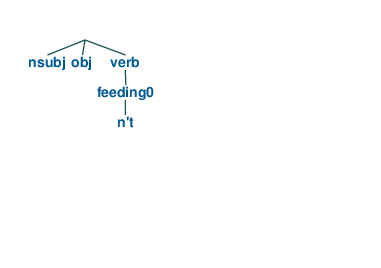

nsubj
obj
verb


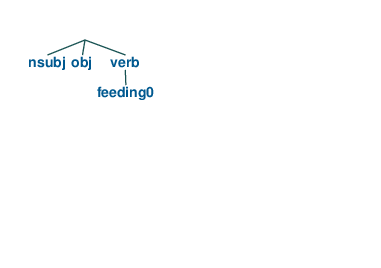

nsubj
nsubj
obj
verb
obj
verb


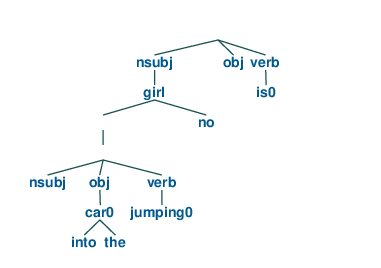

nsubj
obj
verb


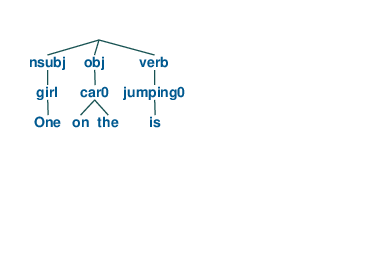

nsubj
obj
verb


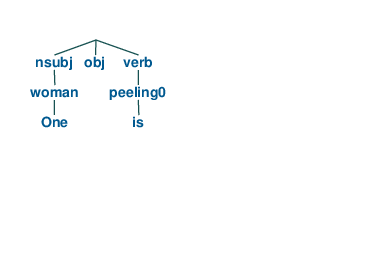

nsubj
nsubj
obj
verb
obj
verb


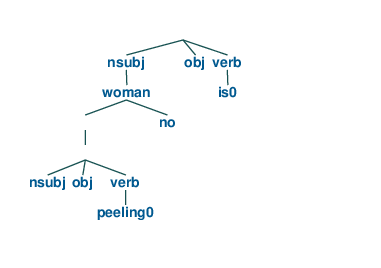

nsubj
obj
verb


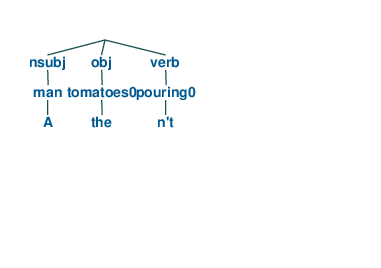

nsubj
obj
verb


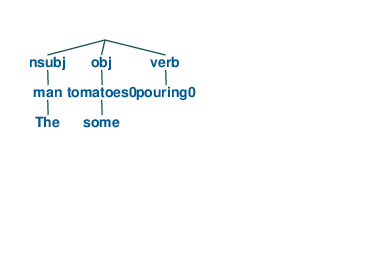

nsubj
nsubj
obj
verb
obj
verb


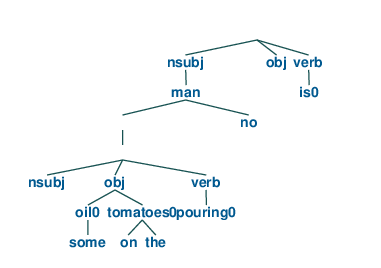

nsubj
obj
verb


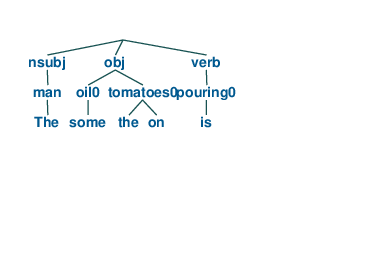

nsubj
obj
verb


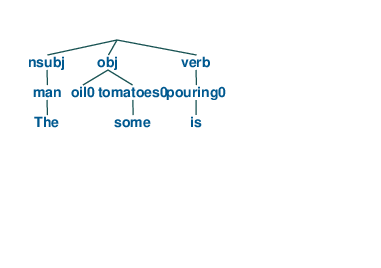

nsubj
nsubj
obj
verb
obj
verb


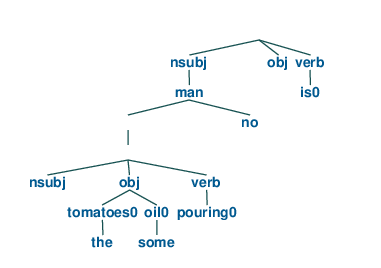

nsubj
obj
verb


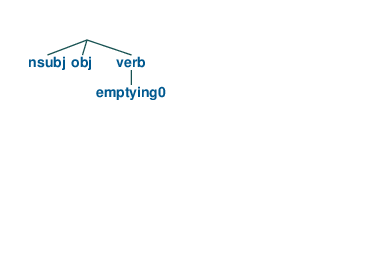

nsubj
obj
verb


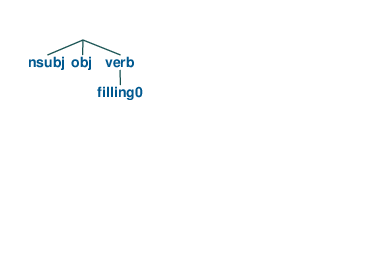

nsubj
obj
verb


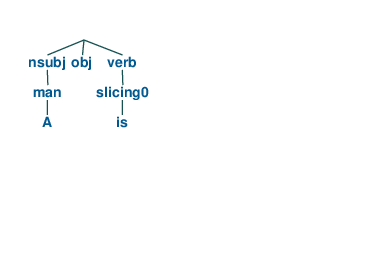

nsubj
nsubj
obj
verb
obj
verb


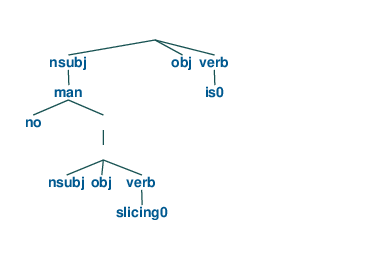

nsubj
obj
verb


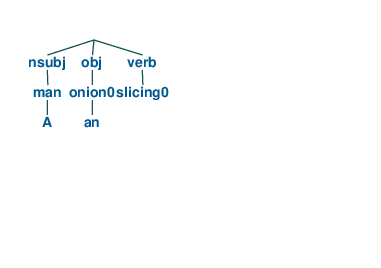

nsubj
obj
verb


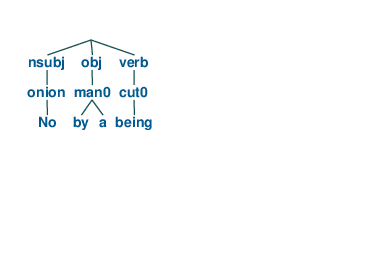

nsubj
nsubj
obj
verb
obj
verb


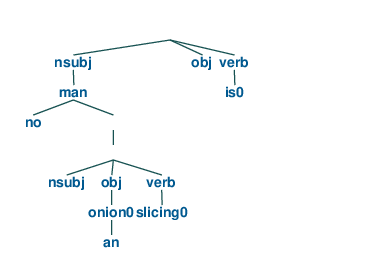

nsubj
obj
verb


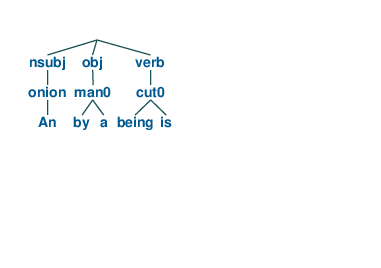

nsubj
obj
verb


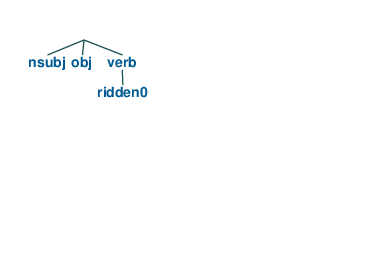

nsubj
obj
verb


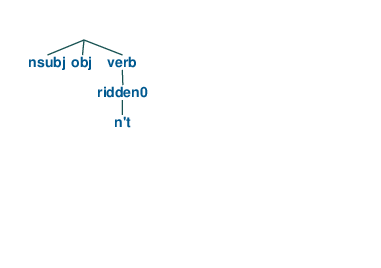

nsubj
obj
verb


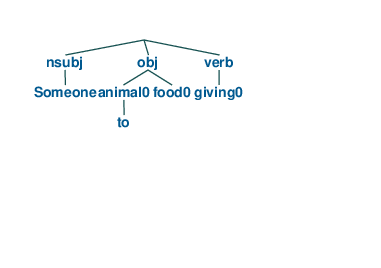

nsubj
obj
verb


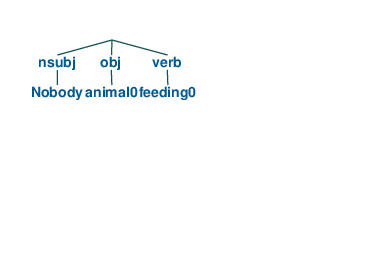

nsubj
obj
verb


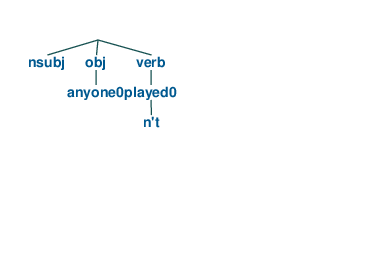

nsubj
obj
verb


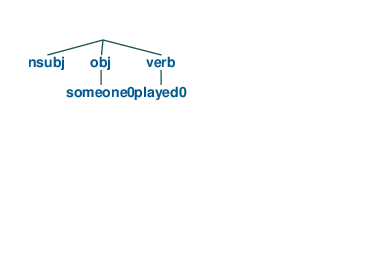

nsubj
obj
verb


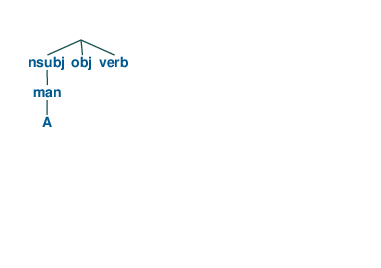

nsubj
obj
verb


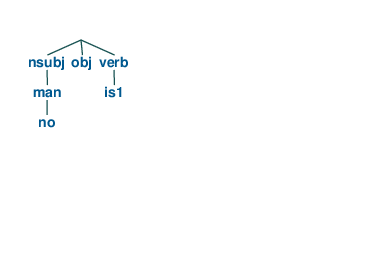

nsubj
nsubj
obj
verb
obj
verb


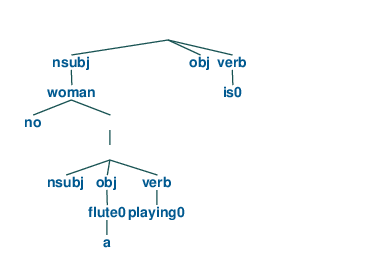

nsubj
obj
verb


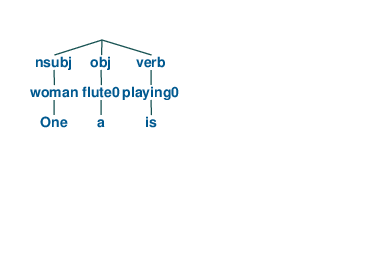

nsubj
obj
verb


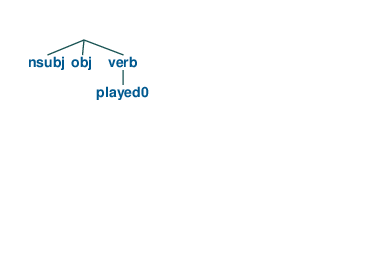

nsubj
obj
verb


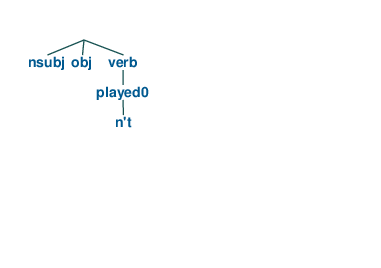

nsubj
obj
verb


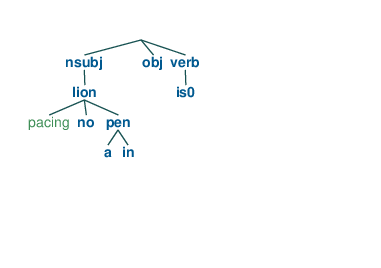

nsubj
obj
verb


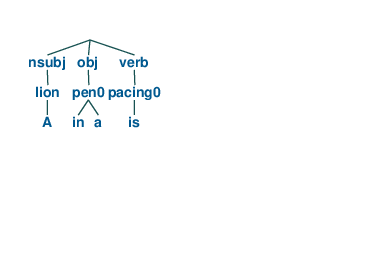

In [69]:
cons = open("../data/SICK/contradict_error_new.txt", "w")
for i in range(int(len(con_p)/10), int(len(con_p)/5)):
    try:
        if(i in [0,6]):
            continue
        ind = False
        tree1 = pipeline.single_polarization(con_p[i])["polarized_tree"]
        tree2 = pipeline.single_polarization(con_hypo[i])["polarized_tree"]
        #jupyter_draw_nltk_tree(Tree.fromstring(pipeline.postprocess(tree1,"").replace('[', '(').replace(']', ')')))
        #jupyter_draw_nltk_tree(Tree.fromstring(pipeline.postprocess(tree2,"").replace('[', '(').replace(']', ')')))
        
        gh1 = mono2Graph(tree1)
        #jupyter_draw_nltk_tree(Tree.fromstring(gh1.get_magicText()))
        gh2 = mono2Graph(tree2)
        #jupyter_draw_nltk_tree(Tree.fromstring(gh2.get_magicText()))
        align_G(gh1, gh2)
        process_graph(gh1,gh2)
        #control_graph(gh1, gh2)
        output = check_con(gh1.root, gh2.root)
        
        if(output == None):
            output = 3
        if(output != 1):
            cons.write(con_p[i])
            cons.write(con_hypo[i])
            cons.write("\n")
            cons.write(str(output))
            cons.write("\n")
        ind = True
            
    except:
        cons.write(con_p[i])
        cons.write(con_hypo[i])
        cons.write("\n")
        cons.write(str(output))
        cons.write("\n")
    if(not ind):
        cons.write(con_p[i])
        cons.write(con_hypo[i])
        cons.write("\n")
        cons.write("error")
        cons.write("\n")
cons.close()

In [ ]:
cons.close()

A man doing a pose is being watched by another man
There is no man in a pose, being watched by another man


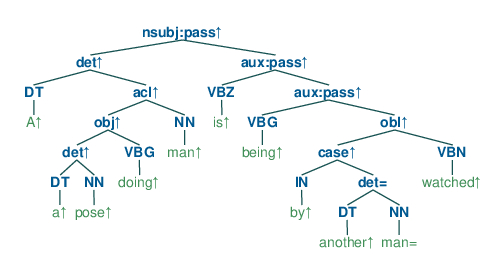

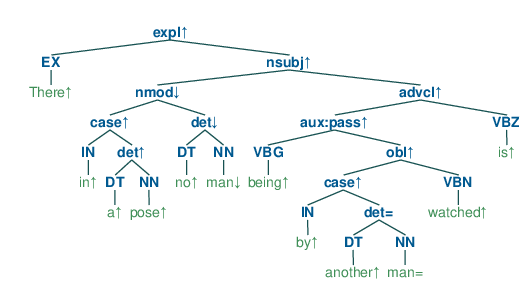

nsubj
nsubj
obj
verb
obj
verb


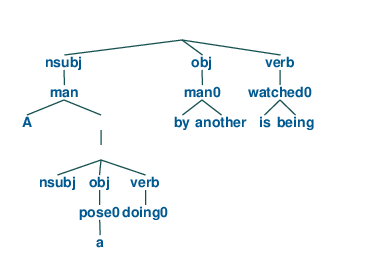

['Somebody is being watched by another man', 'Somebody doing a pose', 'a pose', 'by another man', 'doing a pose', 'is being watched', 'A man doing a pose', 'doing']
nsubj
obj
verb


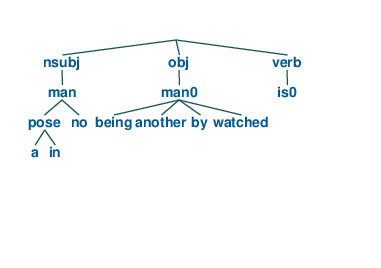

["A => ['no']", "a => ['a']", "pose => ['pose']", "a => ['a', 'a']", "a => ['a', 'a', 'a']", "pose => ['pose', 'pose']", 'Root => []', "man => ['man']"]
nsubj
nsubj
obj
verb
obj
verb


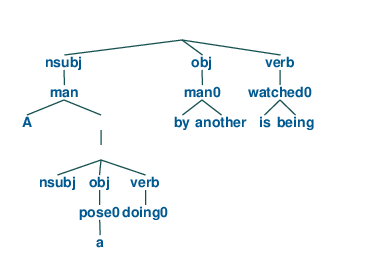

nsubj
obj
verb


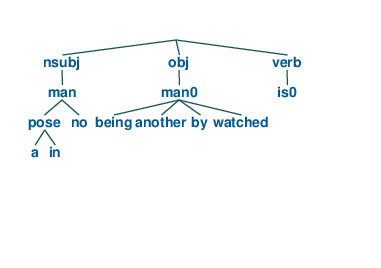

1

In [120]:
pipeline = PolarizationPipeline(verbose = 1)

trees = []
num = 0
sent1 = "A man doing a pose is being watched by another man" #entail_p[num]
sent2 = "There is no man in a pose, being watched by another man"#entail_hypo[num]
print(sent1)
print(sent2)


tree1 = pipeline.single_polarization(sent1)["polarized_tree"]
tree2 = pipeline.single_polarization(sent2)["polarized_tree"]
jupyter_draw_nltk_tree(Tree.fromstring(pipeline.postprocess(tree1,"").replace('[', '(').replace(']', ')')))
jupyter_draw_nltk_tree(Tree.fromstring(pipeline.postprocess(tree2,"").replace('[', '(').replace(']', ')')))

gh1 = mono2Graph(tree1)
jupyter_draw_nltk_tree(Tree.fromstring(gh1.get_magicText()))
toPrint = []
print(make_chunks(gh1, toPrint))

gh2 = mono2Graph(tree2)
jupyter_draw_nltk_tree(Tree.fromstring(gh2.get_magicText()))
align_G(gh1, gh2)
process_graph(gh1,gh2)
control_graph(gh1, gh2)
check_con(gh1.root, gh2.root)


In [98]:
gh1 = mono2Graph(results_tree[4])
jupyter_draw_nltk_tree(Tree.fromstring(gh1.get_magicText()))
gh2 = mono2Graph(results_tree[5])
jupyter_draw_nltk_tree(Tree.fromstring(gh2.get_magicText()))
align_G(gh1, gh2)
process_graph(gh1,gh2)
control_graph(gh1, gh2)

IndexError: list index out of range

In [ ]:
def process_branchS(node1, node2, label = "all"):
    if(node1.isRoot == True and node2.isRoot == True and label == "all"):
            noun,potentialNouns = process_branch(node1, node2, "nsubj")
            verb,potentialVerbs = process_branch(node1, node2, "verb")
            obj,potentialObjs = process_branch(node1, node2, "obj")
            nodes = [node1, node2]
            for i in range(2):
                for toRmverb in potentialVerbs:
                    for toRmobj in potentialObjs:
                        if(toRmverb[i].pair == toRmobj[i].pair and toRmverb[i].pair != -1):
                            nodes[i].nexts["verb"].remove(toRmverb[i])
                            nodes[i].nexts["obj"].remove(toRmobj[i])
            return noun and verb and obj, None
    if(node1.isRoot != node2.isRoot):
        print("Node relating in process_branch() breaks")
        return False,None
    toRemove = set()
    toRemoveContentWords = []
    for next1 in node1.nexts[label]:
        cor = False
        
        for next2 in node2.nexts[label]:
                ###alignment of roots lacking
                print(next1.word, '  ', next2.word)
                if((next1.isRoot == next2.isRoot) and (next1.isRoot or 
                                                       w2v_model.similarity(next1.word.lower(),next2.word.lower()) > 0.85)):
                    tempBool, tempOut = process_branch(next1, next2)
                    if(tempBool):
                        if(label != "all"):

                            toRemoveContentWords.append([next1,next2])
                            break
                        cor = True
                        node2.nexts[label].remove(next2)
                        break
        if(cor):
            toRemove.add(next1)
    #print(list(k.word for k in toRemove))
    #print(list(k.word for k in node2.nexts[label]))
    for item in toRemove:
        
        node1.nexts[label].discard(item)
    #node1.nexts[label] = node1.nexts[label]-toRemove
    if(node1.nexts[label] == set() and node2.nexts[label] == set()):
        return True,toRemoveContentWords
    else:
        
        return False,toRemoveContentWords

In [ ]:
def check_difference(node1, node2, ranks,pos = "all"):
    #indexs: 0->lexical 1->phrasal 2->syntatic variation 3->implicative
    #currently not experted on how a node might be aligned to a root node
    if(not node1.isRoot and not node2.isRoot):
        roots1 = getRootNodes(node1)
        roots2 = getRootNodes(node2)
        rootPassed = set()
        rootPassed1 = set()
        for root1 in roots1:
            tempMaxRoot = [None, 0]
            for root2 in roots2:
                if(root2 not in rootPassed):
                    rank3 = cal_sim_nodes(root1, root2)
                    if(rank3 >= tempMaxRoot[1]):
                        tempMaxRoot[0] = root2
                        tempMaxRoot[1] = rank3
            if(tempMaxRoot[0] is not None):
                rootPassed.add(tempMaxRoot[0])
                outRank = control_direct(root1, root2)[1]
                for i in range(len(outRank)):
                    ranks[i] += outRank[i]
            else:
                rootPassed1.add(root1)
                break
            rootPassed1.add(root1)
        for passedRoot in rootPassed:
            print(pos)
            print(list({itemTemp.word:1 for itemTemp in node1.nexts[pos]}))
            print(passedRoot.word)
            node2.nexts[pos].remove(passedRoot)
        for root1 in rootPassed1:
            node1.nexts[pos].remove(root1)
    
    nextSizes = min(len(node1.nexts[pos]), len(node2.nexts[pos]))
    tracked = set()
    
    for nextNode1 in node1.nexts[pos]:
        
        related = []
        if(nextNode1.isRoot):
            continue
        if(node2.nexts[pos] == set()):
            if(nextNode1.isRoot):
                ranks[2] += 1
            else:
                ranks[1] += 1
            continue
        tempMax = [None, 0]
        for nextNode2 in node2.nexts[pos]:
            if nextNode2 not in tracked and not nextNode2.isRoot:
                rank = cal_sim_nodes(nextNode1, nextNode2, 0.4/nextSizes)
                if(rank >= tempMax[1]):
                    tempMax[0] = nextNode2
                    tempMax[1] = rank
        if(tempMax[0] is None):
            ###not mapping node and root node here
            
            for nodeRoot in node2.nexts[pos]:
                if(nodeRoot not in trakced):
                    root2 = nodeRoot
                    break
            ranks[2] += 1
            tracked.add(root2)
            break
        tracked.add(tempMax[0])
        alignedNode = tempMax[0]
        
        if(nextNode1.nexts["all"] == set()):
            ranks[alignedNode.nexts["all"] != set()] += 1
            
        else:
            if(alignedNode.nexts["all"] == set()):
                ranks[nextNode1.nexts["all"] != set()] += 1                    
            else:
                next_set = [0] * 4
                check_difference(nextNode1, alignedNode, next_set)
                #if(nextNode1.word == "woman"):

                    #print("At node with word(woman): ")
                    #print(len(node1.nexts[pos]))
                    #print(next_set)
                    #print(len(node2.nexts[pos]))
                sumOut = sum(next_set)
                if(sumOut > 1):
                    if(nextNode1.word != alignedNode.word):
                        ##node words not equal and descendents some are different
                        ranks[2] += 1
                    else:
                        ranks[1] += 1
                elif((next_set[0] == 1 and nextNode1.word == alignedNode.word) or 
                    (sumOut == 0 and nextNode1.word != alignedNode.word)):
                    ranks[0] += 1
                elif(sumOut ==1):
                    ranks[1] += 1 ##or simply ranks[0] += 2
                else:
                    print(sumOut)
                    print(nextNode1.word)
                    print(alignedNode.word)
                    
                    print("Error in check_difference because of process_branch")
        
    if(len(node2.nexts[pos]) != len(tracked)):
        for node2_left in node2.nexts[pos]:
            if(node2_left not in tracked):
                if(node2_left.isRoot):
                    ranks[2] += 1
                else:
                    ranks[1] += 1

In [ ]:
def control_direct(sent1, sent2, isRoot = True):
    if(not(isRoot)):
        graph1 = mono2Graph(sent1)  
        graph2 = mono2Graph(sent2)
        root1 = graph1.root
        root2 = graph2.root
    else:
        root1 = sent1
        root2 = sent2
        
    diffs = [0] * 4
    process_branch(root1, root2)
    check_difference(root1, root2, diffs, "nsubj")
    
    tracked = set()
    for verbNode1 in root1.nexts["verb"]:         
        tempMax = [None, 0]
        for verbNode2 in root2.nexts["verb"]:
            if verbNode2 not in tracked:
                #print(verbNode1.word)
                #print(verbNode2.word)
                rank = cal_sim_nodes(verbNode1, verbNode2, 0.6) + cal_sim_nodes(verbNode1.getParts(), verbNode2.getParts(), 0.4)
                if(rank >= tempMax[1]):
                    tempMax[0] = verbNode2
                    tempMax[1] = rank
        if(tempMax[0] is None):
            if(verbNode1.isRoot):
                diffs[2] += 1
            else:
                diffs[1] += 1
            continue
        tracked.add(tempMax[0])
        check_difference(verbNode1, tempMax[0], diffs)
        ###only check the first obj node with verb now
        if(verbNode1.getParts() != set() and verbNode2.getParts() != set()):
            check_difference(next(iter(verbNode1.getParts())), next(iter(tempMax[0].getParts())), diffs)
            ##print("AfterObj:")
            ##print(diffs)
    if(len(root2.nexts["verb"]) != len(tracked)):
        for node2_left in root2.nexts["verb"]:
            if(node2_left not in tracked):
                if(node2_left.isRoot):
                    diffs[2] += 1
                else:
                    diffs[1] += 1
    return [directions[diffs.index(max(diffs))] ,diffs]

In [ ]:
w2v_model.similarity("The", "Japanese")

In [ ]:
gh1 = mono2Graph(results_tree[0])
jupyter_draw_nltk_tree(Tree.fromstring(gh1.get_magicText()))
gh2 = mono2Graph(results_tree[1])
jupyter_draw_nltk_tree(Tree.fromstring(gh2.get_magicText()))
control_direct(results_tree[0],results_tree[1],False)

In [ ]:
for i in range(3):
   test = 1
print(test) 

In [ ]:
w2v_model = api.load("glove-wiki-gigaword-50")

In [ ]:
w2v_model.similarity("empty", "not empty")

In [ ]:
w2v_model.similarity("girl", "woman")

In [ ]:
#print(control_direct(results_tree[0], results_tree[1],False))
print(testExtract[0])
print(testExtract[1])


print(w2v_model.similarity('car','vehicle'))

tree1 = pipeline.single_polarization(testExtract[0])["polarized_tree"]
tree2 = pipeline.single_polarization(testExtract[1])["polarized_tree"]
jupyter_draw_nltk_tree(Tree.fromstring(pipeline.postprocess(tree1,"").replace('[', '(').replace(']', ')')))
jupyter_draw_nltk_tree(Tree.fromstring(pipeline.postprocess(tree2,"").replace('[', '(').replace(']', ')')))
g1 = mono2Graph(tree1)
g2 = mono2Graph(tree2)
process_branch(g1.root,g2.root)
jupyter_draw_nltk_tree(Tree.fromstring(g1.get_magicText()))
jupyter_draw_nltk_tree(Tree.fromstring(g2.get_magicText()))
print("RESULT:")
print(control_direct(tree1, tree2,False)[1])
print("ABOVE IS RESULT")



In [ ]:
print(w2v_model.similarity("fruit", "banana"))
print(w2v_model.similarity( "apple", "banana"))
w2v_model.similarity("fruit","apple")

In [ ]:
dict1 = {1:"2"}
dict1[1]

In [ ]:
A = {2,4}
print(i for i in A)
B = [3,5]
B[1!=0] += 1
print(B)

In [ ]:
list({None, 5})

In [ ]:
test1 = Unode("root", "root", "root", "root")
testSet = set()
testSet.add(test1)
testSet.remove(test1)
testSet

In [ ]:
#get_word_sets("car","hypernym")

In [ ]:
check_alignment(G1, G2)

In [ ]:
ae = set()
def return1(i):
    return
ae.add(return1(2))
ae

In [ ]:
find_relation("running", "sleeping", "vb")

In [ ]:
find_relation("people","person",'nn')

In [ ]:
if(1==0):
    t = 3
else:
    t = 5
print(t)

In [ ]:
None == None